In [97]:
# This is necessary to include the project directory into system paths
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [118]:
# Now we can import from project directory
from project.src.data_classes import SCOTUS, Opinion

fuck you sami to the end
['fuck', 'sami', 'end']


In [93]:
# Libraries for analysis, we want to abstract functionality into classes that can be imported above as we test/develop in Jupyter 
# This way, we work with classes (for Juypter use) and build out from there
# Try and build classes that encapsulates different constitute parts of the NLP
import pandas as pd
from collections import Counter
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.util import ngrams
import string
from nltk.corpus import stopwords
from itertools import combinations
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,10)

In [49]:
# usecols = ['author_name', 'category', 'per_curiam', 'case_name', 'year_filed', 'text']
# since_1970 = pd.read_csv('scotus/opinions_since_1970.csv', usecols=usecols)
# all_opinions = pd.read_csv('scotus/all_opinions.csv', usecols=usecols)
scotus_data = SCOTUS()
all_opinions = scotus_data.all_opinions


In [80]:
# https://gist.github.com/emaadmanzoor/1d06e0751a3f7d39bc6814941b37531d
test_text = all_opinions.head().at[0, 'text']
opinion_text = OpinionPreprocessing(test_text)



NameError: name 'OpinionPreprocessing' is not defined

In [4]:
# Counters for each justice encounter

class JusticeOpinionCounter:

    def __init__(self, author_name):
        self.texts = []
        self.unigram_counter = Counter()
        self.bigram_counter = Counter()
        self.trigram_counter = Counter()

    def add_opinion(self, text):
        self.texts.append(text)
     
        #         Clean and tokenize
        #         obvious-ly => obvious ly (lemmatization)
        words = ''.join((filter(lambda x: x in string.printable, text))).replace('\n', ' ')
        # print(type(words), len(words))
        words = words.replace('–', '')
        # print(type(words), len(words))
        table = str.maketrans('', '', string.punctuation+'’‘'+'“”'+'–'+string.digits+'­')
        words = [w.translate(table).lower() for w in words.split()]
        # print(type(words), len(words))
        stop_words = stopwords.words('english')
        words = list(filter(lambda w: w not in stop_words, words))
        # print(type(words), len(words))
        words = list(filter(lambda w: w.isalpha(), words))
        
        self.unigram_counter.update(list(ngrams(words, 1)))
        self.bigram_counter.update(list(ngrams(words, 2)))
        self.trigram_counter.update(list(ngrams(words, 3)))
        # print(len(words), len(self.unigram_counter.keys()), len(self.bigram_counter.keys()))

In [5]:
for x, op in all_opinions[['author_name', 'text']][0:10].iterrows():
    print()
    if (op['author_name'] == 'Justice Thomas'):
        print(op['text'])
        # print(len())



I adhere to the view that this Court’s decision in Buckley

v. Valeo, 424 U.S. 1 (1976) (per curiam), denigrates core
First Amendment speech and should be overruled. See
Randall v. Sorrell, 548 U.S. 230, 265–267 (2006)
(THOMAS, J., concurring in judgment); Federal Election
Comm’n v. Beaumont, 539 U.S. 146, 164–165 (2003)
(THOMAS, J., dissenting); Federal Election Comm’n v.
Colorado Republican Federal Campaign Comm., 533 U.S.
431, 465–466 (2001) (Colorado II) (THOMAS, J., dissent-
ing); Nixon v. Shrink Missouri Government PAC, 528 U.S.
377, 412–420 (2000) (THOMAS, J., dissenting); Colorado
Republican Federal Campaign Comm. v. Federal Election
Comm’n, 518 U.S. 604, 635–640 (1996) (Colorado I )
(THOMAS, J., concurring in judgment and dissenting in
part).
   Political speech is “ ‘the primary object of First Amend-
ment protection’ ” and “the lifeblood of a self-governing
people.” Colorado II, supra, at 465–466 (THOMAS, J.,
dissenting). Contributions to political campaigns, no less
than 

In [6]:
def opinion_counter(df):
    op_counters = {}
    for i, op in df[['author_name', 'text']][:1000].iterrows():
        author_name = op['author_name']
        if author_name not in op_counters:
            op_counters[author_name] = JusticeOpinionCounter(author_name)
        op_counters[author_name].add_opinion(op['text'])
    return op_counters

In [7]:
%%time
op_counters = opinion_counter(all_opinions)
len(all_opinions)

CPU times: user 9.97 s, sys: 159 ms, total: 10.1 s
Wall time: 10.1 s


35781

In [8]:
op_counters

{'Justice Roberts': <__main__.JusticeOpinionCounter at 0x7f8d3be7a520>,
 'Justice Thomas': <__main__.JusticeOpinionCounter at 0x7f8d3be7a7c0>,
 'Justice Breyer': <__main__.JusticeOpinionCounter at 0x7f8d3be7a700>,
 'Justice Taney': <__main__.JusticeOpinionCounter at 0x7f8d3bdbc3a0>,
 'Justice Pitney': <__main__.JusticeOpinionCounter at 0x7f8d3bdbc340>,
 'Justice Harlan': <__main__.JusticeOpinionCounter at 0x7f8d3bdba2e0>,
 'per_curiam': <__main__.JusticeOpinionCounter at 0x7f8d3bdbd4f0>,
 'Justice Miller': <__main__.JusticeOpinionCounter at 0x7f8d3bdba490>,
 'Justice Frankfurter': <__main__.JusticeOpinionCounter at 0x7f8d3bdbc940>,
 'Justice Swayne': <__main__.JusticeOpinionCounter at 0x7f8d3bdbcdc0>,
 'Justice Douglas': <__main__.JusticeOpinionCounter at 0x7f8d3bd137c0>,
 'Justice Holmes': <__main__.JusticeOpinionCounter at 0x7f8d3bdba160>,
 'Justice White': <__main__.JusticeOpinionCounter at 0x7f8d3bc29f70>,
 'Justice Hunt': <__main__.JusticeOpinionCounter at 0x7f8d3bac6760>,
 'Justi

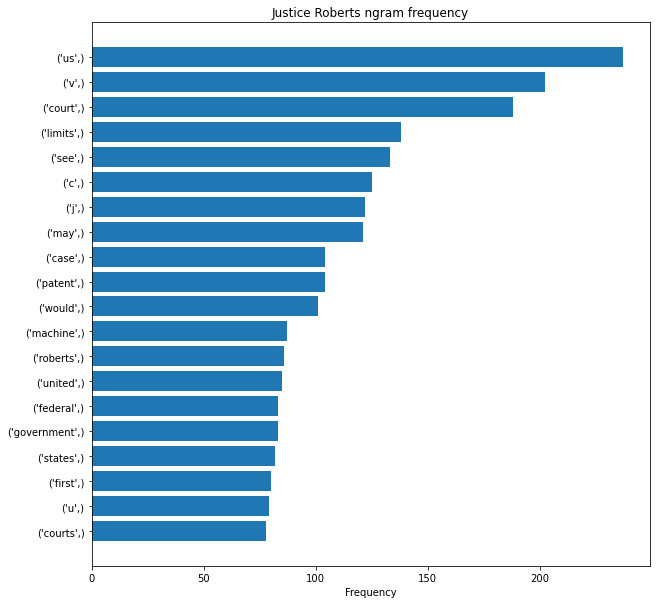

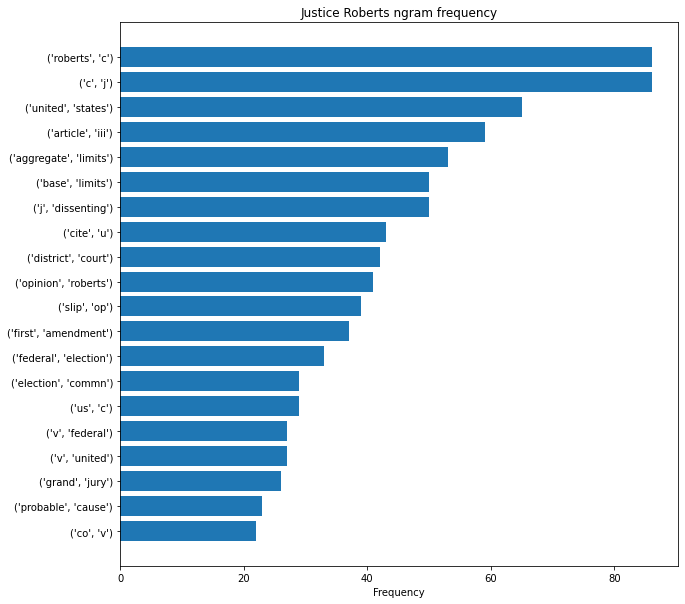

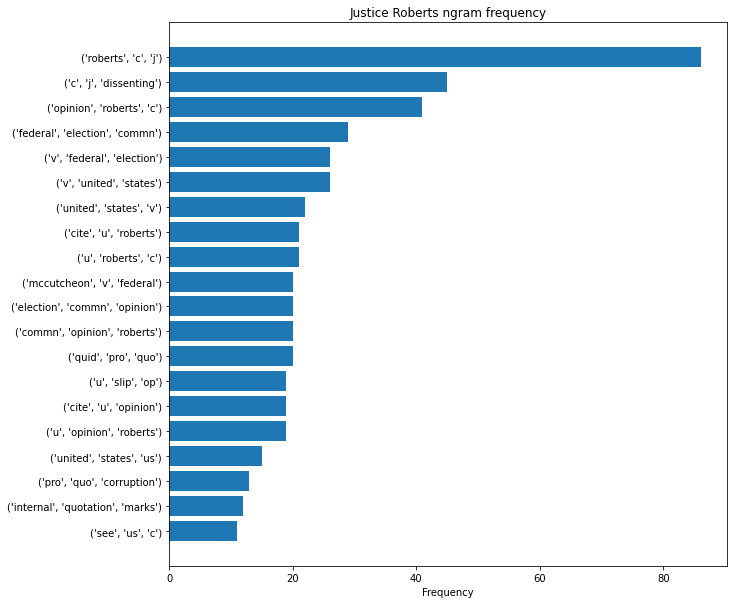

In [9]:
def ngram_barchart(most_common, author_name):
    fig, ax = plt.subplots()
    # Example data
    tokens = list(map(lambda token_freq: token_freq[0], most_common))
    y_pos = np.arange(len(tokens))
    freqs = list(map(lambda token_freq: token_freq[1], most_common))
    
    ax.barh(y_pos, freqs, align='center')
    ax.set_yticks(y_pos, labels=tokens)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Frequency')
    ax.set_title(f'{author_name} ngram frequency')
    plt.show()
    
def most_common_barchart(op_counters, author_name, top=20):
    most_common_uni = op_counters[author_name].unigram_counter.most_common()[:top]
    most_common_bi = op_counters[author_name].bigram_counter.most_common()[:top]
    most_common_tri = op_counters[author_name].trigram_counter.most_common()[:top]
    ngram_barchart(most_common_uni, author_name)
    ngram_barchart(most_common_bi, author_name)
    ngram_barchart(most_common_tri, author_name)
    
    
most_common_barchart(op_counters, 'Justice Roberts')

In [10]:
def print_most_common(op_counters, author_name, top=10):
    min_token_len = lambda w: len(w) >= 1
    counter = op_counters[author_name]
    print(author_name)
    print('\t unigrams:')
    [print(f'\t\t{k} {v}') for k,v in counter.unigram_counter.most_common(top)]
    print('\t bigrams:')
    [print(f'\t\t{k} {v}') for k,v in counter.bigram_counter.most_common(top) if all(map(min_token_len, k))]
    print('\t trigrams:')
    [print(f'\t\t{k} {v}') for k,v in counter.trigram_counter.most_common(top) if all(map(min_token_len, k))]
    
print_most_common(op_counters, 'Justice Roberts')

Justice Roberts
	 unigrams:
		('us',) 237
		('v',) 202
		('court',) 188
		('limits',) 138
		('see',) 133
		('c',) 125
		('j',) 122
		('may',) 121
		('case',) 104
		('patent',) 104
	 bigrams:
		('roberts', 'c') 86
		('c', 'j') 86
		('united', 'states') 65
		('article', 'iii') 59
		('aggregate', 'limits') 53
		('base', 'limits') 50
		('j', 'dissenting') 50
		('cite', 'u') 43
		('district', 'court') 42
		('opinion', 'roberts') 41
	 trigrams:
		('roberts', 'c', 'j') 86
		('c', 'j', 'dissenting') 45
		('opinion', 'roberts', 'c') 41
		('federal', 'election', 'commn') 29
		('v', 'federal', 'election') 26
		('v', 'united', 'states') 26
		('united', 'states', 'v') 22
		('cite', 'u', 'roberts') 21
		('u', 'roberts', 'c') 21
		('mccutcheon', 'v', 'federal') 20


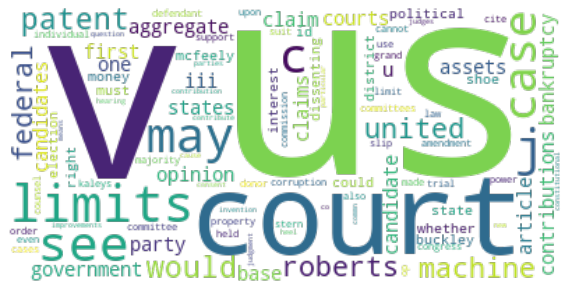

In [11]:
# for x, op in all_opinions[['author_name', 'text']][0:10].iterrows():
#     print()
#     if (op['author_name'] == 'Justice Thomas'):
#         print(op['text'])
#         # print(len())

def unigram_wordcloud(op_counters, author_name):
    wordcloud_unigrams = dict([[k[0],v] for k,v in op_counters[author_name].unigram_counter.items()])
    wordcloud = WordCloud(background_color=None, mode='RGBA', max_words=100).generate_from_frequencies(wordcloud_unigrams)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
unigram_wordcloud(op_counters, 'Justice Roberts')

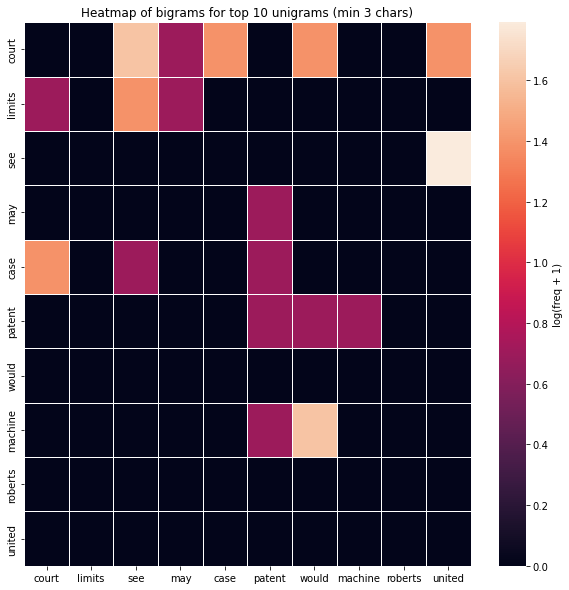

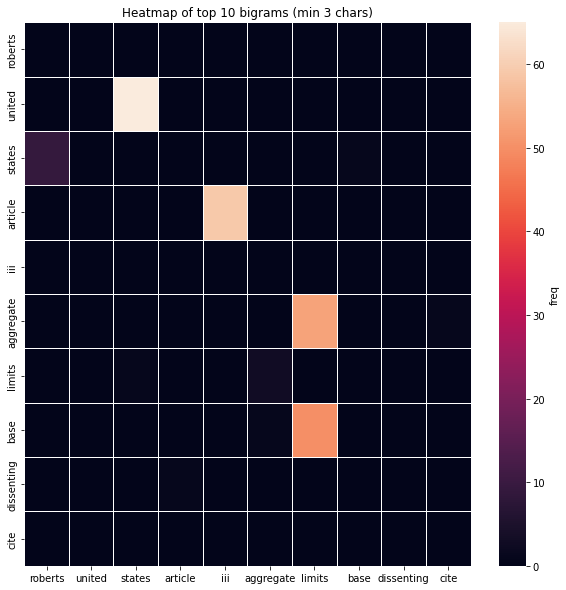

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 65,  0,  0,  0,  0,  0,  0,  0],
       [ 9,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0, 59,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 53,  0,  0,  1],
       [ 0,  0,  1,  0,  0,  3,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1, 50,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [12]:
def most_common_unigram_heatmap(op_counters, author_name, top=10):
    min_token_len = 3
    most_common = op_counters[author_name].unigram_counter.most_common()
    top_unigrams = [k[0] for k, v in most_common if len(k[0]) >= min_token_len][:top]
    i2t = dict([[k,v] for k,v in enumerate(top_unigrams)])
    heatmap_bigram = np.zeros((top,top), int)
    for i in range(top):
        for j in range(top):
            heatmap_bigram[i,j] = op_counters[author_name].bigram_counter[(i2t[i], i2t[j])]
    heatmap_bigram = np.log(heatmap_bigram + 1)
    ax = sns.heatmap(heatmap_bigram, linewidth=0.5,  xticklabels=top_unigrams, yticklabels=top_unigrams, cbar_kws={'label': 'log(freq + 1)'})
    plt.title(f'Heatmap of bigrams for top {top} unigrams (min {min_token_len} chars)')
    plt.show()
    return heatmap_bigram
            
def most_common_bigram_heatmap(op_counters, author_name, top=10):
    min_token_len = 3
    most_common = op_counters[author_name].bigram_counter.most_common()
    tokens = []
    for bigram, freq in most_common:
        for token in bigram:
            if token not in tokens and len(token) >= min_token_len:
                tokens.append(token)
    top_tokens = tokens[:top]
    
    i2t = dict([[k,v] for k,v in enumerate(top_tokens)])
    heatmap_bigram = np.zeros((top,top), int)
    for i in range(top):
        for j in range(top):
            heatmap_bigram[i,j] = op_counters[author_name].bigram_counter[(i2t[i], i2t[j])]
    # heatmap_bigram = np.log(heatmap_bigram + 1)
    ax = sns.heatmap(heatmap_bigram, linewidth=0.5, xticklabels=top_tokens, yticklabels=top_tokens, cbar_kws={'label': 'freq'})
    plt.title(f'Heatmap of top {top} bigrams (min {min_token_len} chars)')
    plt.show()
    return heatmap_bigram

most_common_unigram_heatmap(op_counters, 'Justice Roberts')
most_common_bigram_heatmap(op_counters, 'Justice Roberts')





Justice Pitney
	 unigrams:
		('upon',) 200
		('court',) 177
		('state',) 157
		('v',) 155
		('us',) 122
		('act',) 99
		('right',) 91
		('property',) 90
		('co',) 85
		('states',) 75
	 bigrams:
		('united', 'states') 64
		('co', 'v') 56
		('state', 'court') 41
		('plaintiff', 'error') 22
		('supreme', 'court') 22
		('circuit', 'court') 21
		('lake', 'washington') 20
		('interstate', 'commerce') 19
		('salmon', 'bay') 18
		('plaintiffs', 'error') 17
	 trigrams:
		('james', 'b', 'mclaughlin') 8
		('united', 'states', 'circuit') 8
		('states', 'circuit', 'court') 8
		('john', 'r', 'mclaughlin') 7
		('due', 'process', 'law') 7
		('employers', 'liability', 'law') 7
		('tel', 'co', 'v') 7
		('ry', 'co', 'v') 6
		('rr', 'co', 'v') 6
		('determine', 'oilbearing', 'character') 6


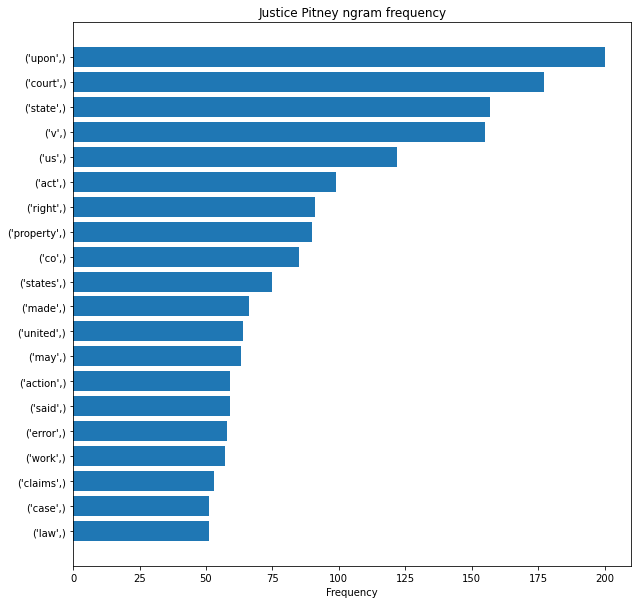

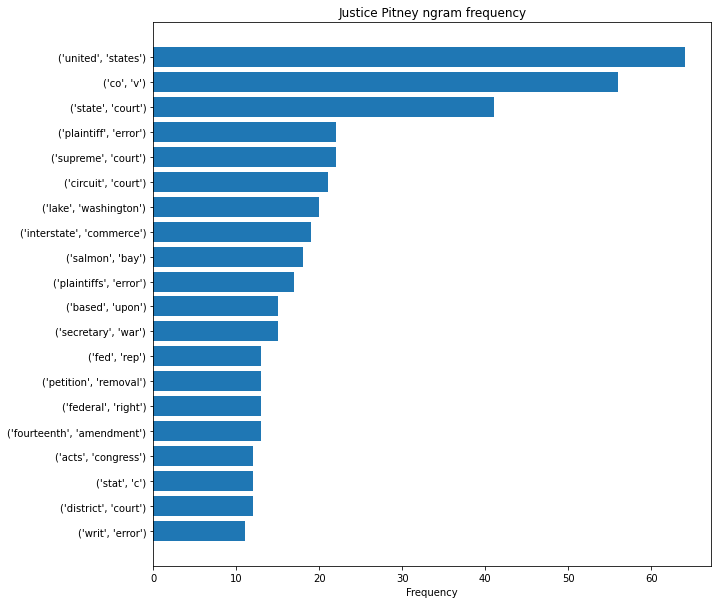

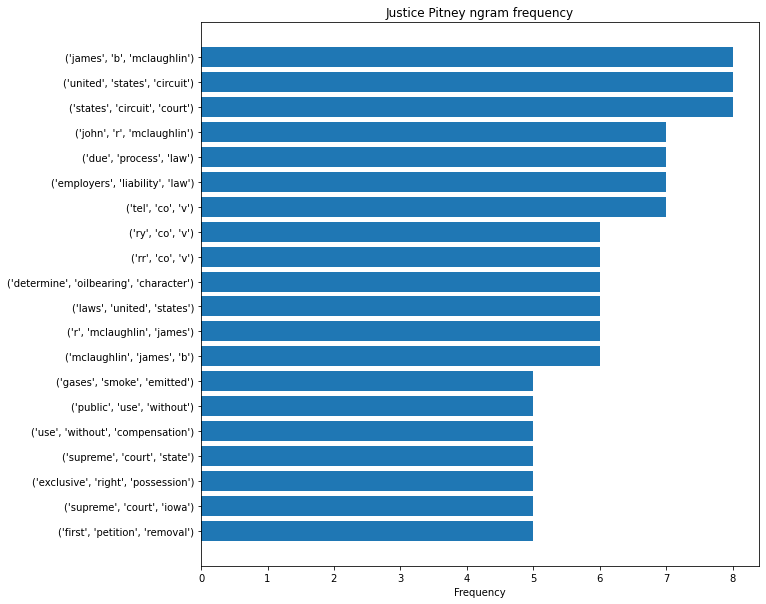

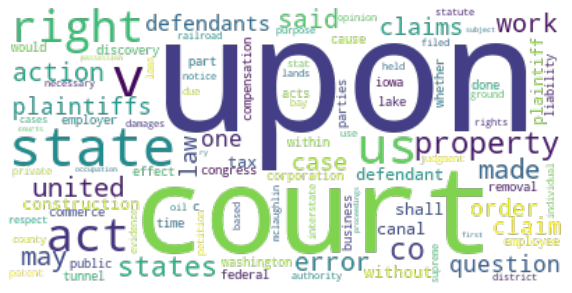

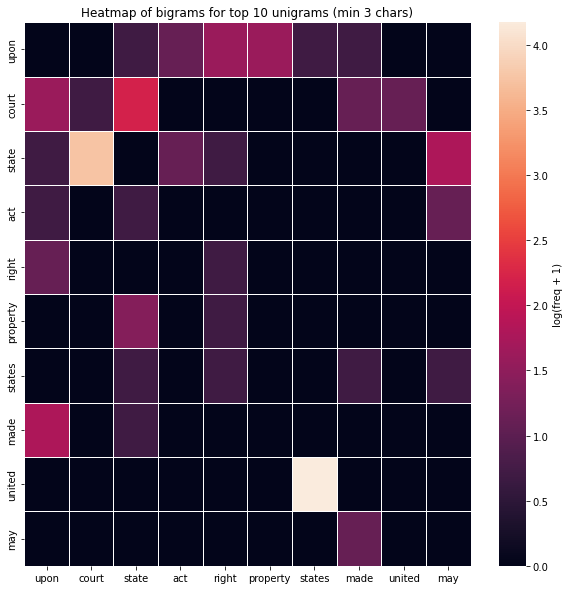

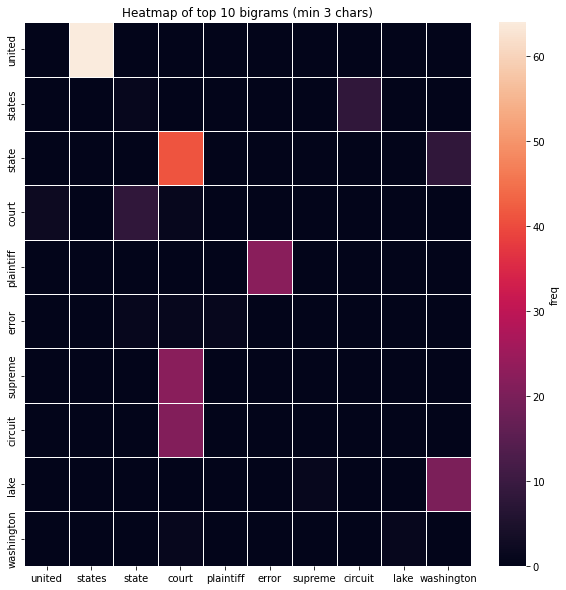

In [13]:
def summarize(op_counters, author_name):
    print_most_common(op_counters, author_name)
    most_common_barchart(op_counters, author_name)
    unigram_wordcloud(op_counters, author_name)
    most_common_unigram_heatmap(op_counters, author_name)
    most_common_bigram_heatmap(op_counters, author_name)
summarize(op_counters, 'Justice Pitney')

In [14]:
def print_justices(df):
    justices = list(set(df['author_name']))
    print(f'{len(justices)} opinion authors')
    # [print(f'\t{j}') for j in justices]6
    return justices

def print_cases(df):
    cases = list(set(df['case_name']))
    print(f'{len(cases)} cases')
    # [print(f'\t{c}') for c in cases]
    return cases

def select_opinions_df(df, author_names=None, case_names=None):
    # Filter opinions that are not 'per_curiam' (by the court)
    opinions = df[df['per_curiam'] == False]
    if author_names is not None:
        opinions = opinions.loc[opinions['author_name'].isin(author_names)]
    if case_names is not None:
        opinions = opinions.loc[opinions['case_name'].isin(case_names)]
    
    cases = print_cases(opinions)
    justices = print_justices(opinions)
    return cases, justices, opinions

7 cases
15 opinion authors
Justice Brennan
	 unigrams:
		('persons',) 32
		('court',) 31
		('v',) 31
		('contraceptives',) 30
		('massachusetts',) 26
		('rights',) 23
		('statute',) 23
		('us',) 19
		('married',) 19
		('baird',) 18
	 bigrams:
		('court', 'appeals') 14
		('unmarried', 'persons') 12
		('commonwealth', 'v') 9
		('married', 'persons') 8
		('massachusetts', 'general') 7
		('general', 'laws') 7
		('laws', 'ann') 7
		('ann', 'c') 7
		('mass', 'ned') 7
		('equal', 'protection') 7
	 trigrams:
		('massachusetts', 'general', 'laws') 7
		('laws', 'ann', 'c') 7
		('general', 'laws', 'ann') 6
		('supreme', 'judicial', 'court') 6
		('commonwealth', 'v', 'baird') 6
		('equal', 'protection', 'clause') 6
		('v', 'baird', 'mass') 4
		('baird', 'mass', 'ned') 4
		('denied', 'access', 'contraceptives') 4
		('persons', 'may', 'obtain') 3


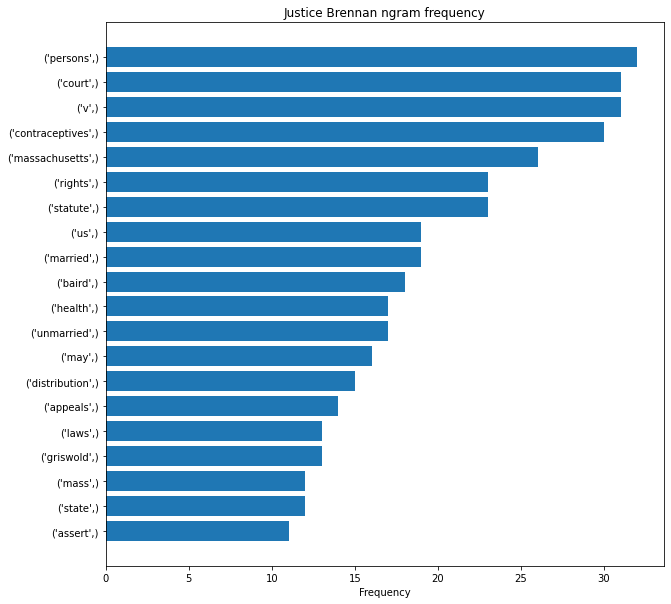

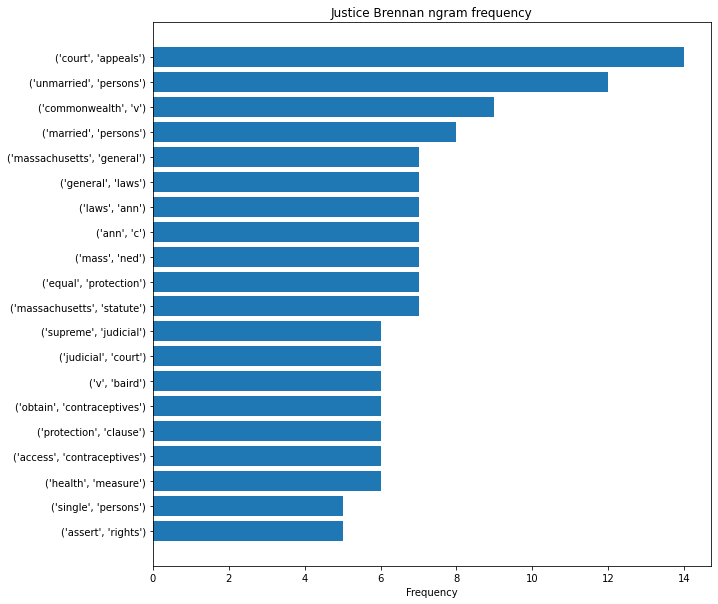

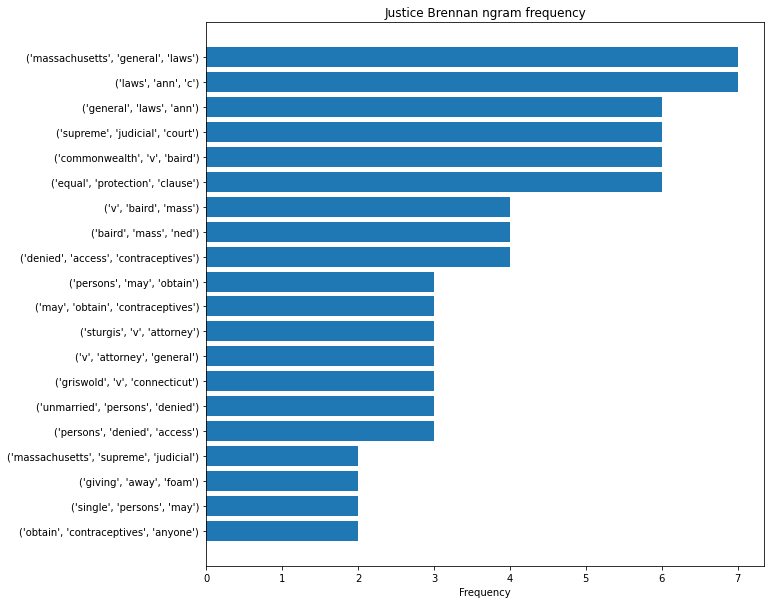

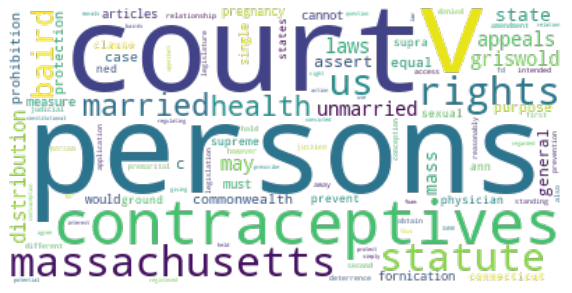

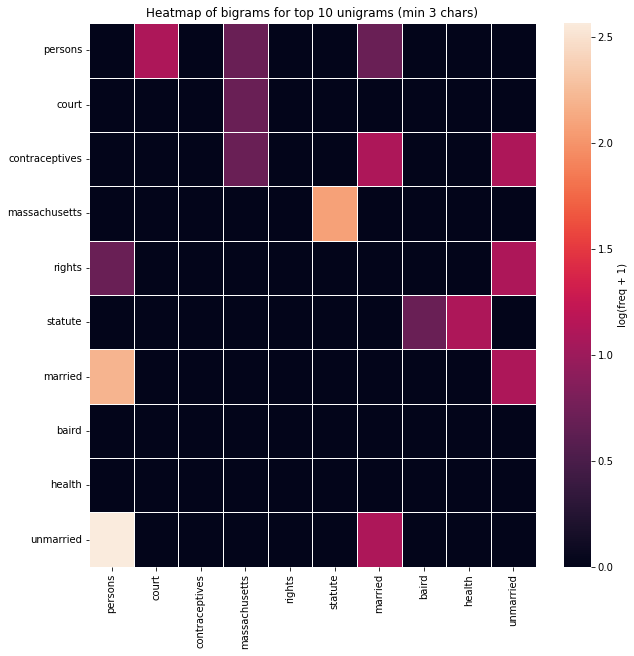

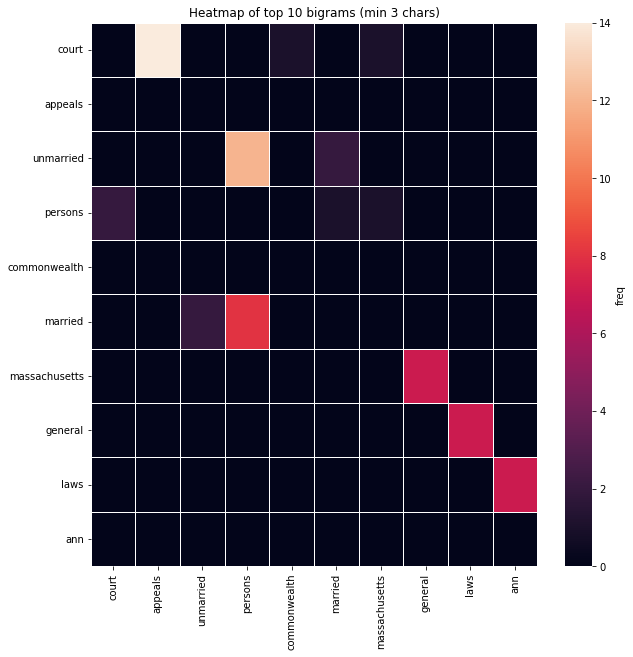

Justice Ginsburg
	 unigrams:
		('court',) 162
		('see',) 161
		('health',) 131
		('us',) 130
		('v',) 111
		('religious',) 101
		('ante',) 93
		('abortion',) 81
		('ct',) 66
		('j',) 66
	 bigrams:
		('us', 'ct') 49
		('hobby', 'lobby') 49
		('j', 'dissenting') 41
		('ginsburg', 'j') 39
		('see', 'also') 38
		('planned', 'parenthood') 34
		('intact', 'e') 31
		('see', 'ante') 26
		('us', 'c') 24
		('et', 'al') 23
	 trigrams:
		('ginsburg', 'j', 'dissenting') 34
		('hobby', 'lobby', 'conestoga') 21
		('hobby', 'lobby', 'stores') 19
		('lobby', 'stores', 'inc') 19
		('v', 'hobby', 'lobby') 18
		('burwell', 'v', 'hobby') 17
		('stores', 'inc', 'ginsburg') 17
		('inc', 'ginsburg', 'j') 17
		('cite', 'u', 'ginsburg') 17
		('u', 'ginsburg', 'j') 17


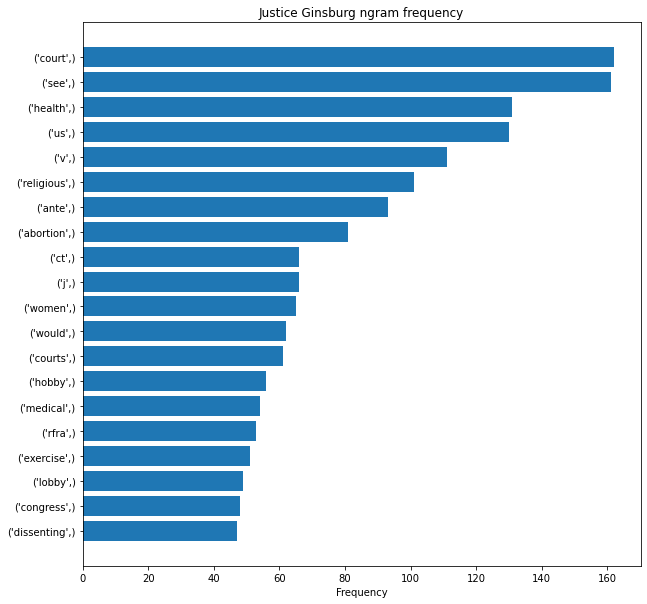

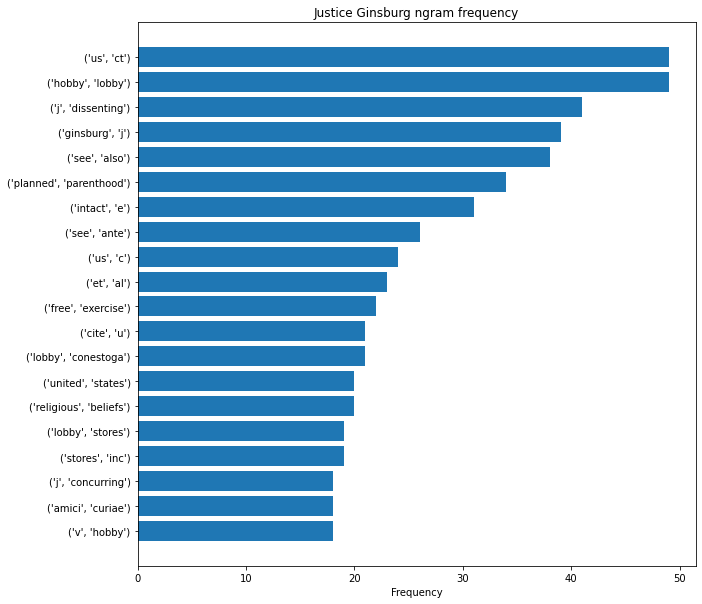

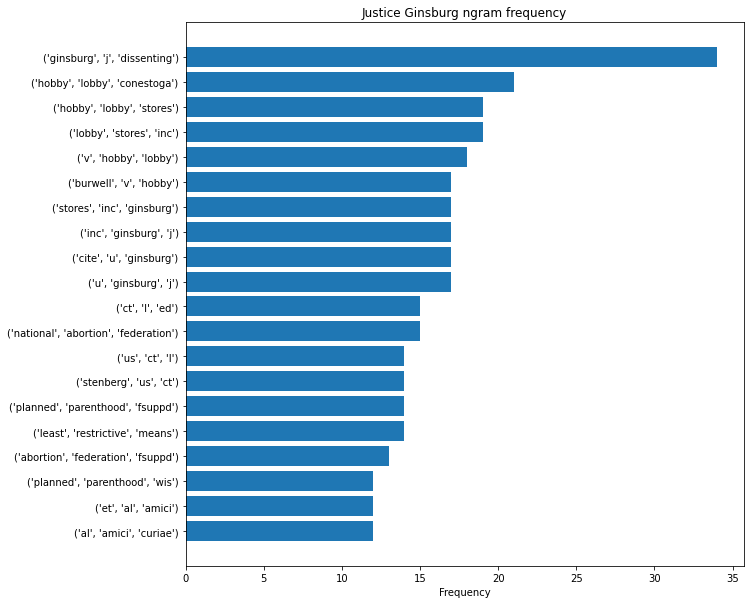

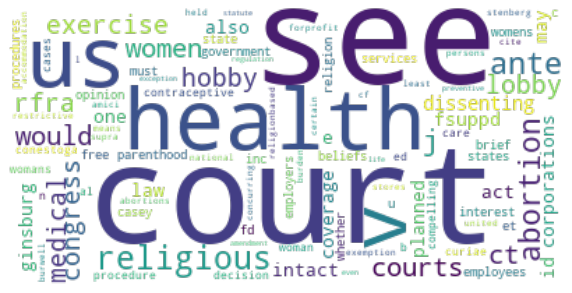

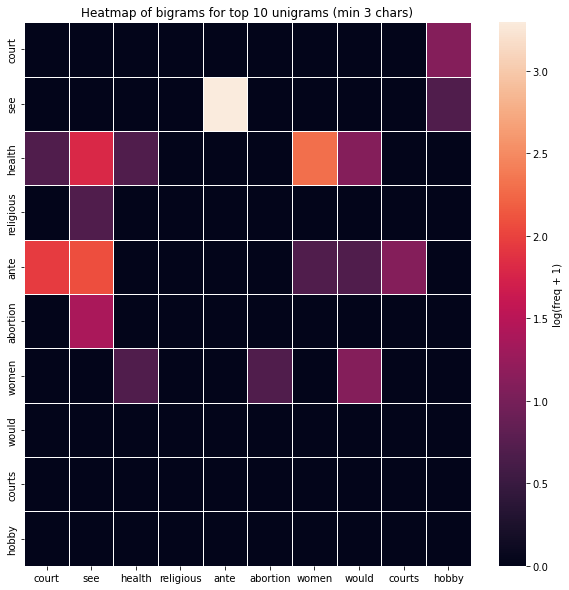

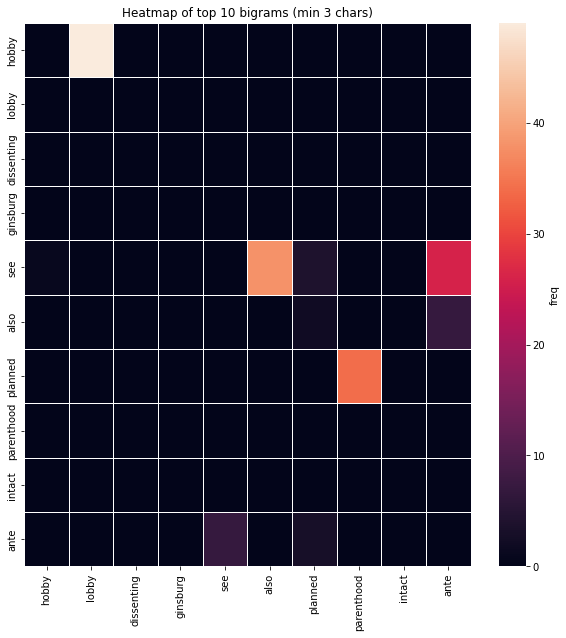

Justice Black
	 unigrams:
		('v',) 33
		('us',) 29
		('law',) 28
		('court',) 28
		('state',) 25
		('amendment',) 23
		('constitutional',) 21
		('power',) 21
		('would',) 20
		('laws',) 20
	 bigrams:
		('due', 'process') 14
		('connecticut', 'law') 10
		('ninth', 'amendment') 9
		('first', 'amendment') 8
		('white', 'goldberg') 6
		('process', 'clause') 6
		('brothers', 'harlan') 5
		('harlan', 'white') 5
		('e', 'g') 5
		('new', 'york') 5
	 trigrams:
		('due', 'process', 'clause') 6
		('brothers', 'harlan', 'white') 5
		('lochner', 'v', 'new') 4
		('v', 'new', 'york') 4
		('law', 'due', 'process') 4
		('harlan', 'white', 'goldberg') 3
		('see', 'e', 'g') 3
		('first', 'amendment', 'freedoms') 3
		('brothers', 'white', 'goldberg') 3
		('new', 'york', 'us') 3


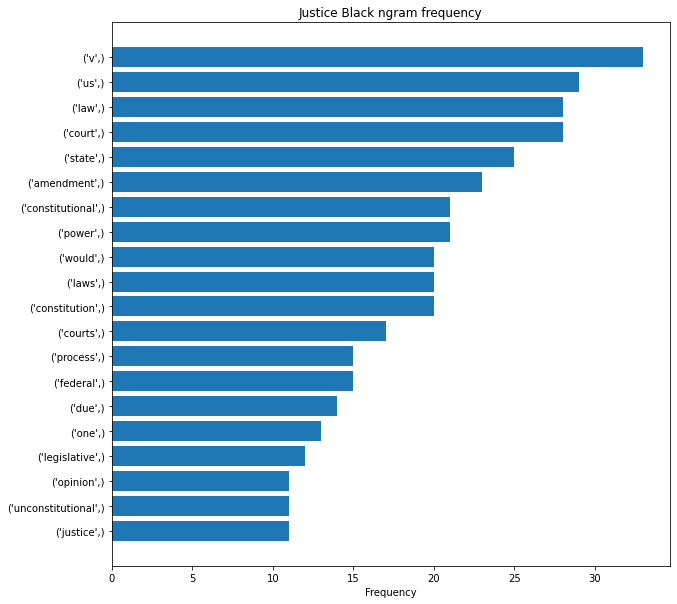

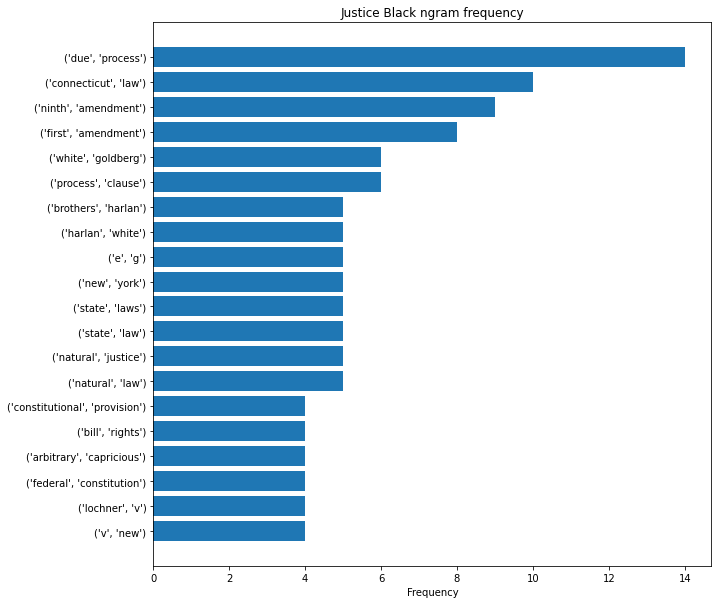

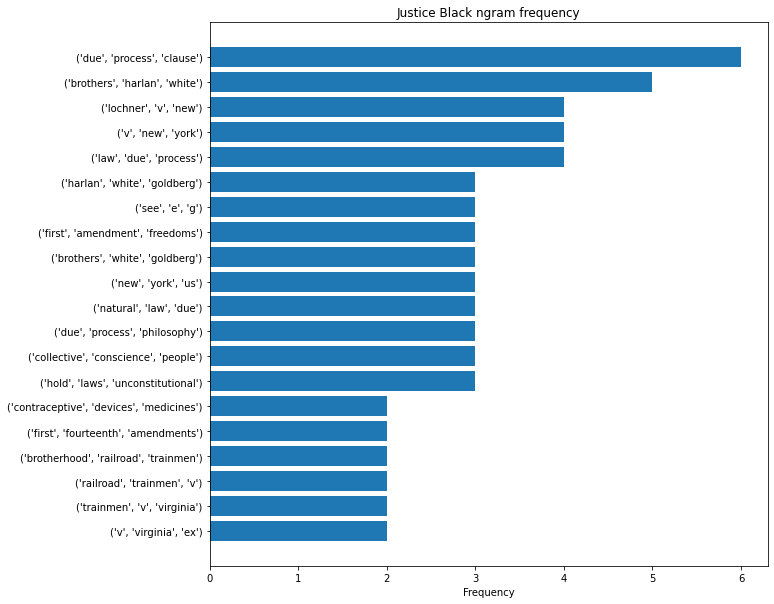

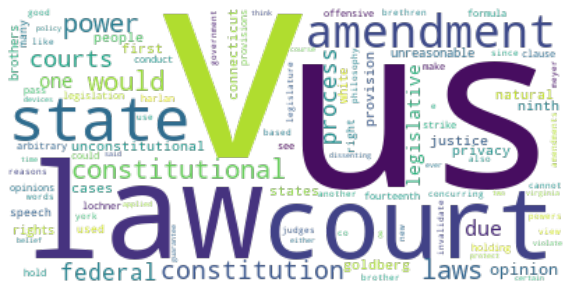

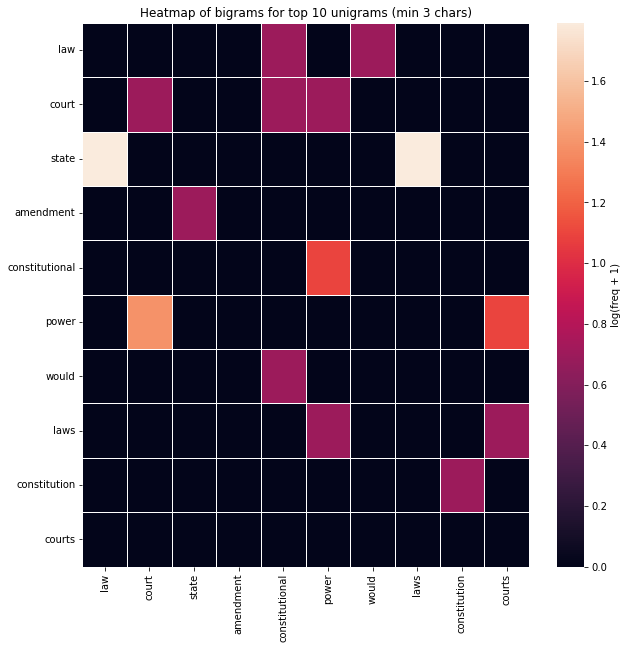

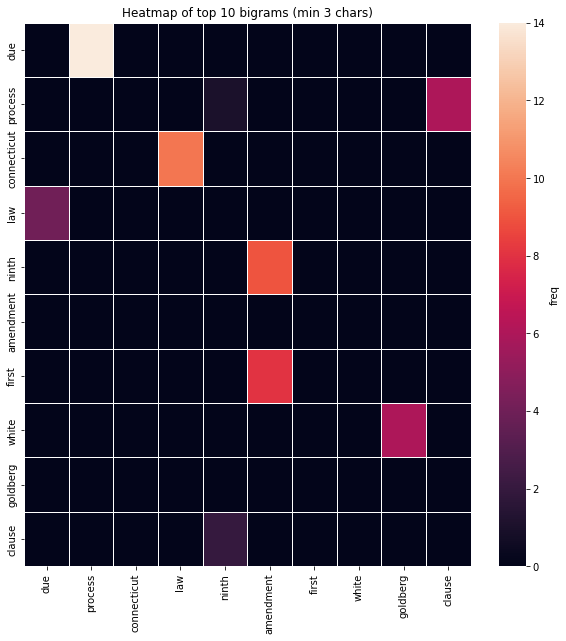

Justice Scalia
	 unigrams:
		('abortion',) 236
		('procedure',) 150
		('fetus',) 119
		('court',) 101
		('medical',) 98
		('birth',) 93
		('state',) 91
		('partial',) 90
		('id',) 86
		('v',) 83
	 bigrams:
		('partial', 'birth') 83
		('birth', 'abortion') 80
		('unborn', 'child') 31
		('abortion', 'procedure') 25
		('dr', 'carhart') 23
		('justice', 'oconnor') 23
		('testimony', 'dr') 20
		('f', 'supp') 18
		('united', 'states') 17
		('health', 'exception') 17
	 trigrams:
		('partial', 'birth', 'abortion') 80
		('birth', 'abortion', 'procedure') 14
		('living', 'unborn', 'child') 12
		('majority', 'justice', 'oconnor') 10
		('id', 'testimony', 'dr') 9
		('interest', 'potential', 'life') 8
		('internal', 'quotation', 'marks') 8
		('quotation', 'marks', 'omitted') 8
		('app', 'testimony', 'dr') 8
		('unborn', 'child', 'substantial') 7


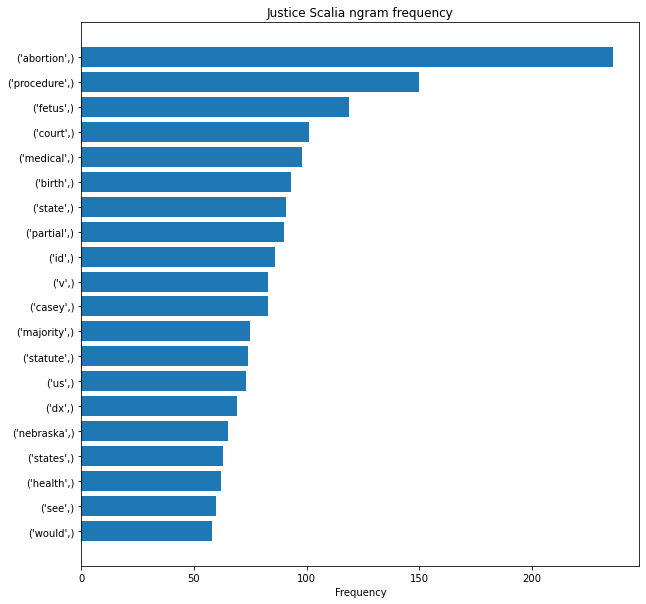

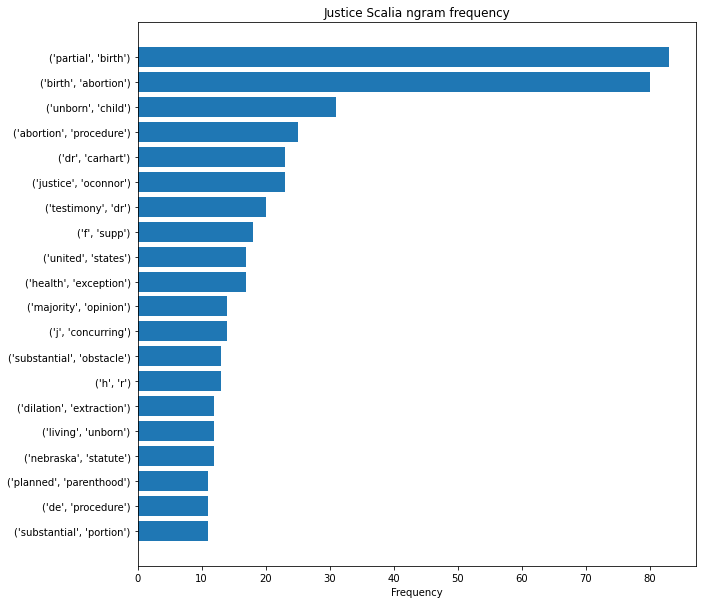

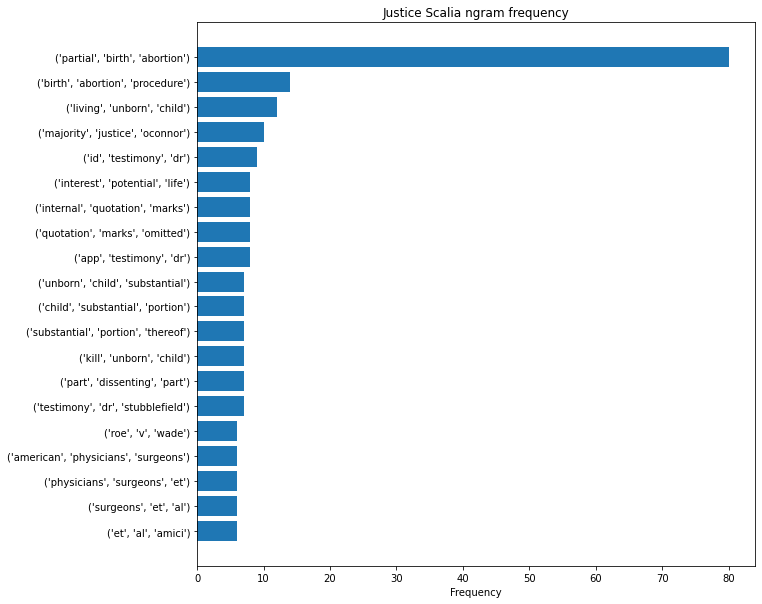

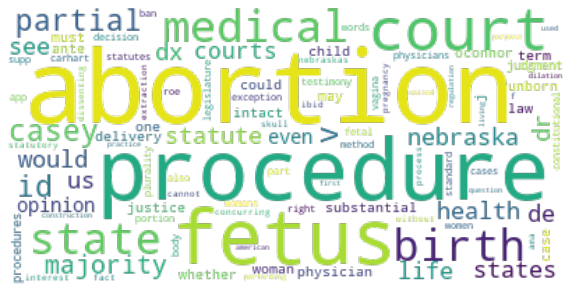

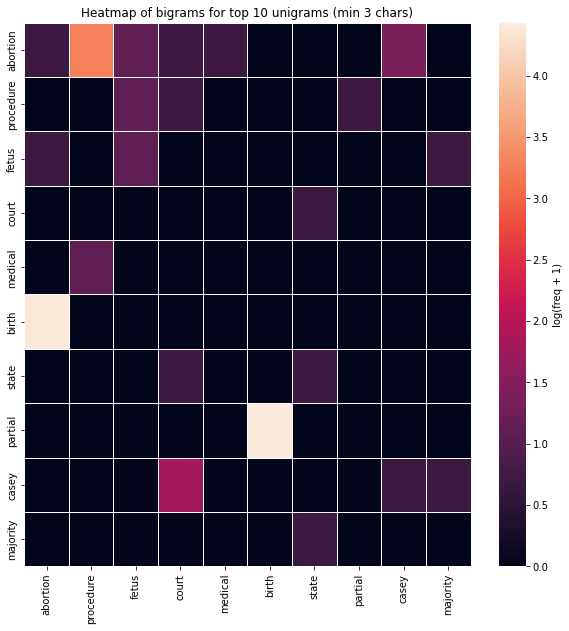

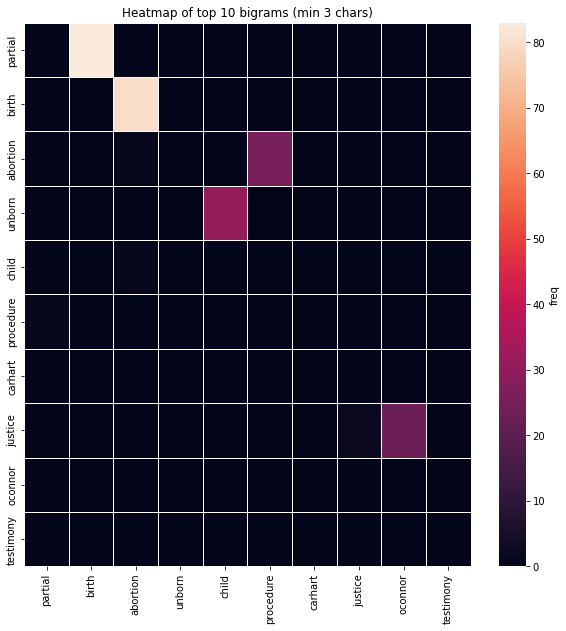

Justice Rehnquist
	 unigrams:
		('court',) 17
		('opinion',) 15
		('us',) 14
		('v',) 13
		('amendment',) 13
		('state',) 12
		('fourteenth',) 11
		('abortion',) 10
		('courts',) 9
		('may',) 9
	 bigrams:
		('fourteenth', 'amendment') 11
		('courts', 'opinion') 7
		('texas', 'statute') 6
		('due', 'process') 5
		('first', 'trimester') 4
		('trimester', 'pregnancy') 4
		('state', 'interest') 4
		('may', 'impose') 3
		('new', 'york') 3
		('mr', 'justice') 3
	 trigrams:
		('first', 'trimester', 'pregnancy') 3
		('clause', 'fourteenth', 'amendment') 3
		('compelling', 'state', 'interest') 3
		('state', 'may', 'impose') 2
		('may', 'impose', 'virtually') 2
		('v', 'united', 'states') 2
		('united', 'states', 'us') 2
		('deprivation', 'without', 'due') 2
		('without', 'due', 'process') 2
		('rational', 'relation', 'valid') 2


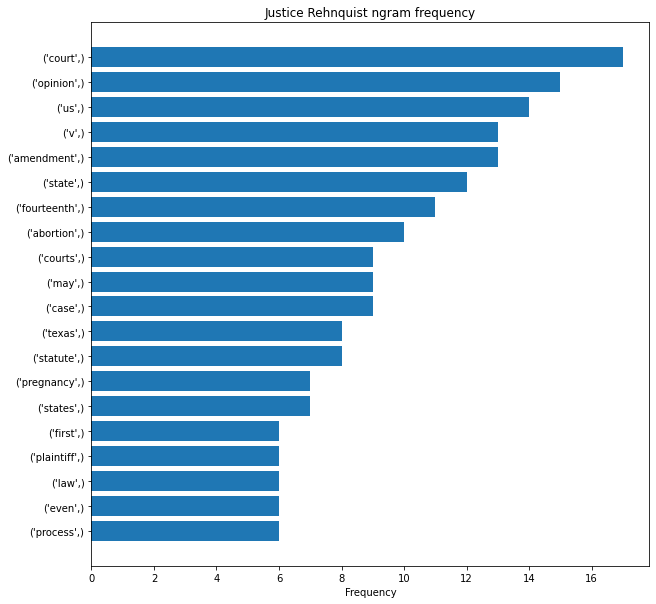

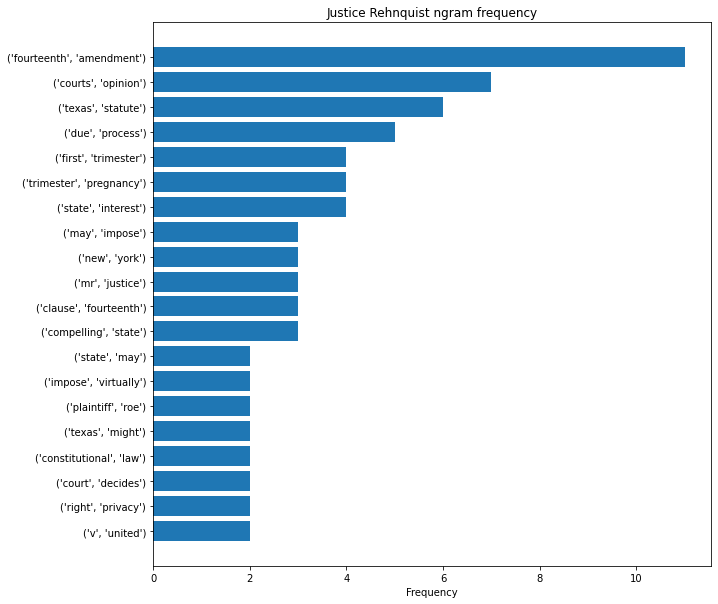

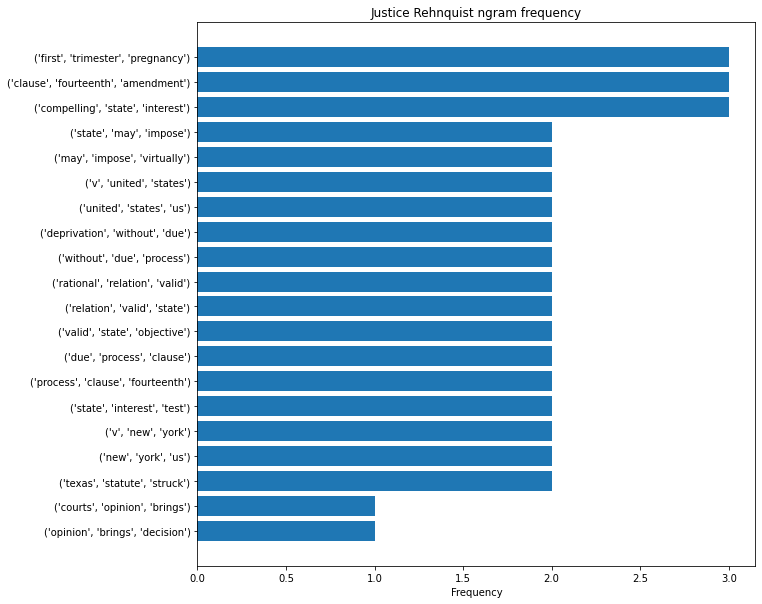

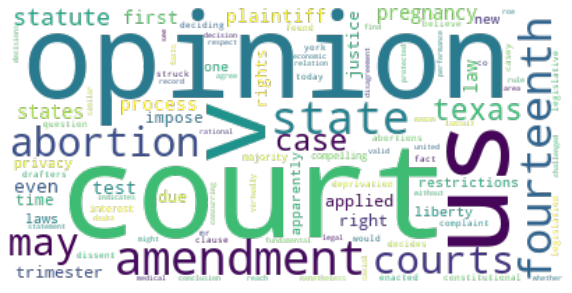

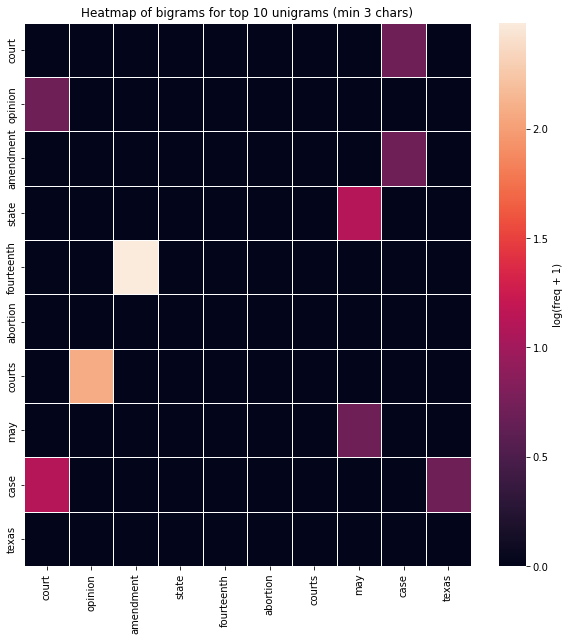

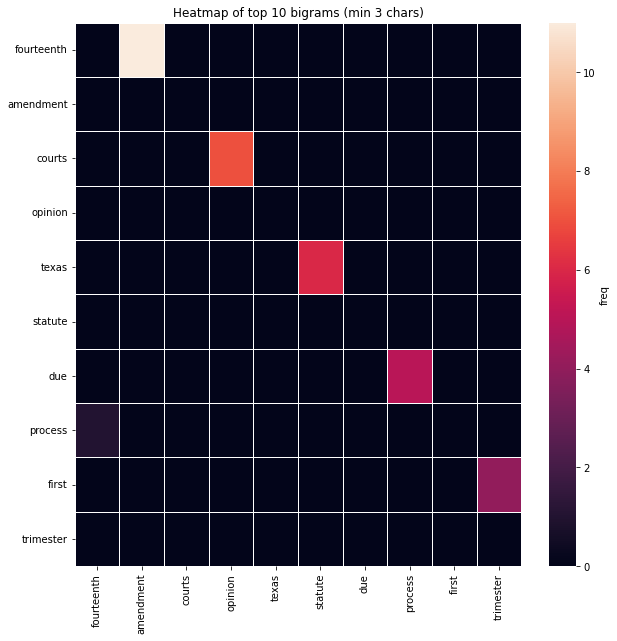

Justice Stewart
	 unigrams:
		('v',) 29
		('us',) 26
		('law',) 17
		('court',) 16
		('amendment',) 15
		('process',) 13
		('connecticut',) 13
		('due',) 12
		('right',) 12
		('state',) 11
	 bigrams:
		('due', 'process') 12
		('fourteenth', 'amendment') 9
		('process', 'clause') 9
		('clause', 'fourteenth') 7
		('ninth', 'amendment') 5
		('connecticut', 'law') 4
		('bill', 'rights') 4
		('protected', 'due') 4
		('united', 'states') 4
		('ferguson', 'v') 3
	 trigrams:
		('due', 'process', 'clause') 9
		('process', 'clause', 'fourteenth') 7
		('clause', 'fourteenth', 'amendment') 7
		('protected', 'due', 'process') 4
		('ferguson', 'v', 'skrupa') 3
		('liberty', 'protected', 'due') 3
		('pierce', 'v', 'society') 3
		('v', 'society', 'sisters') 3
		('meyer', 'v', 'nebraska') 3
		('v', 'skrupa', 'us') 2


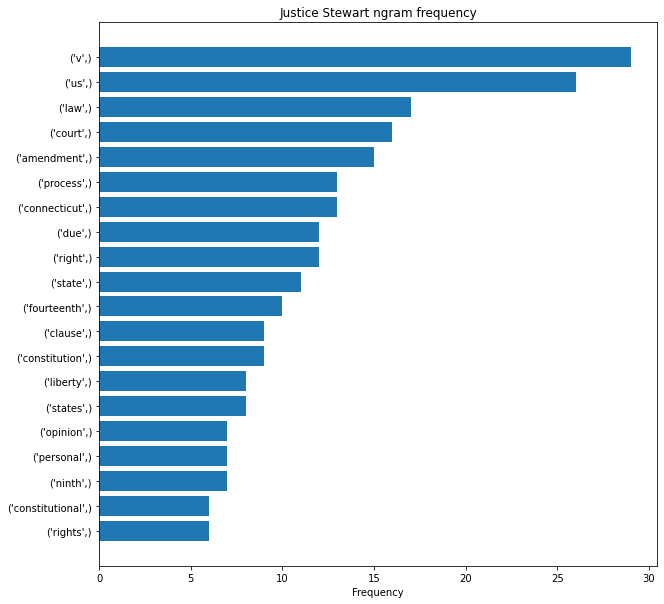

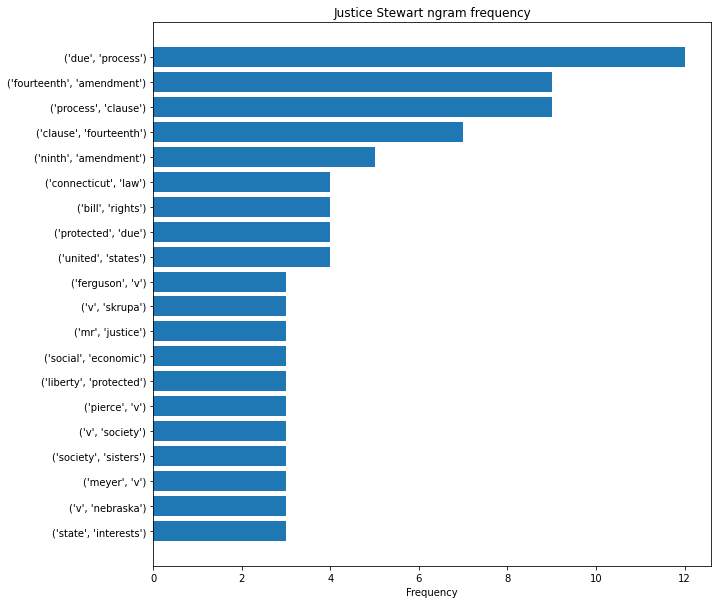

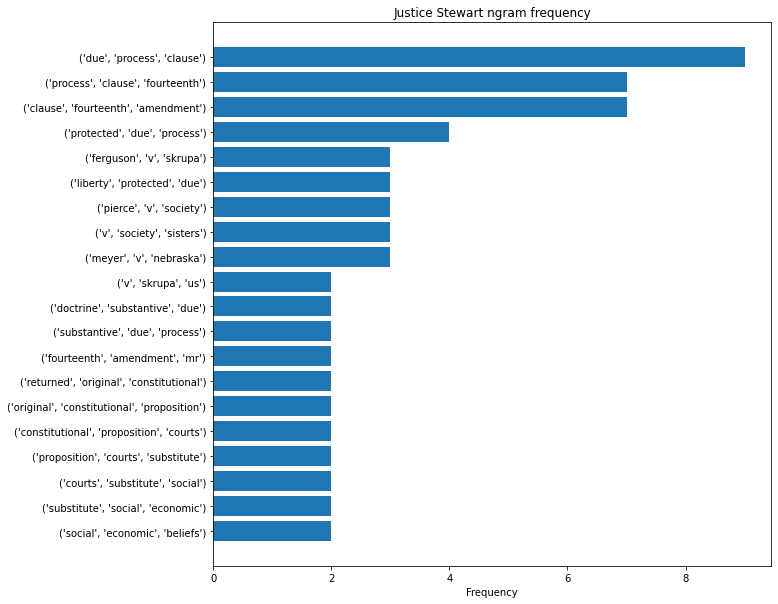

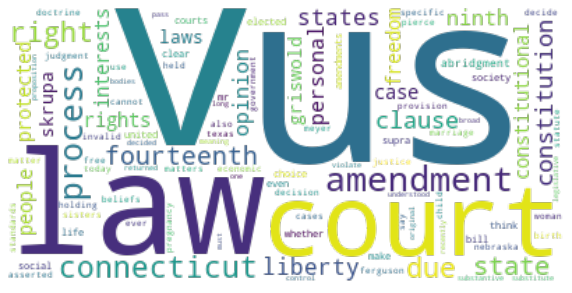

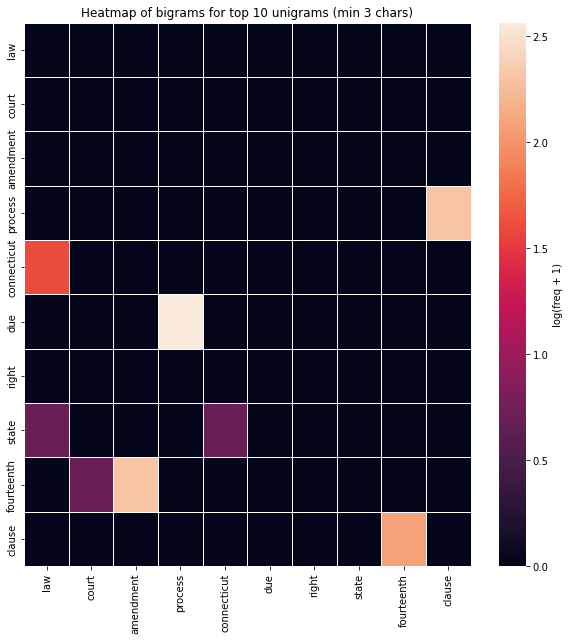

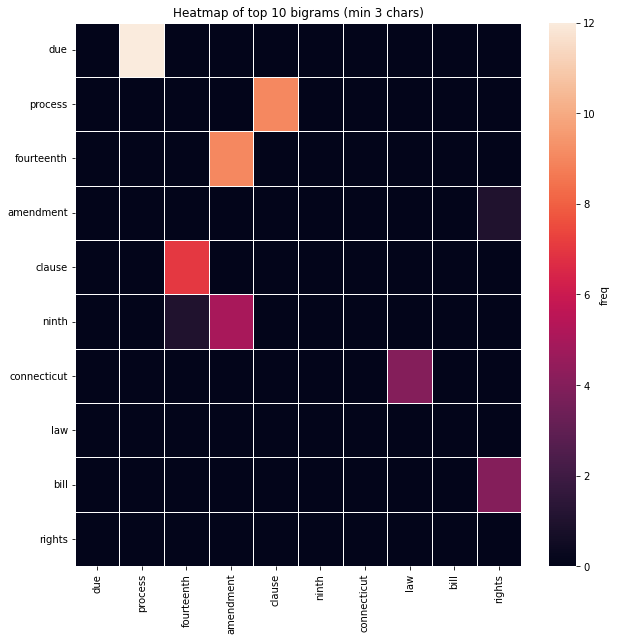

Justice Douglas
	 unigrams:
		('v',) 61
		('us',) 57
		('right',) 34
		('amendment',) 24
		('rights',) 23
		('baird',) 20
		('first',) 18
		('may',) 18
		('one',) 17
		('freedom',) 13
	 bigrams:
		('first', 'amendment') 16
		('vaginal', 'foam') 8
		('birth', 'control') 5
		('married', 'persons') 5
		('use', 'contraceptives') 5
		('naacp', 'v') 5
		('contraceptive', 'devices') 4
		('giving', 'away') 4
		('griswold', 'v') 4
		('v', 'connecticut') 4
	 trigrams:
		('griswold', 'v', 'connecticut') 4
		('v', 'alabama', 'us') 4
		('first', 'amendment', 'rights') 3
		('make', 'public', 'speech') 3
		('pierce', 'v', 'society') 3
		('v', 'society', 'sisters') 3
		('meyer', 'v', 'nebraska') 3
		('v', 'nebraska', 'us') 3
		('v', 'new', 'york') 3
		('new', 'york', 'us') 3


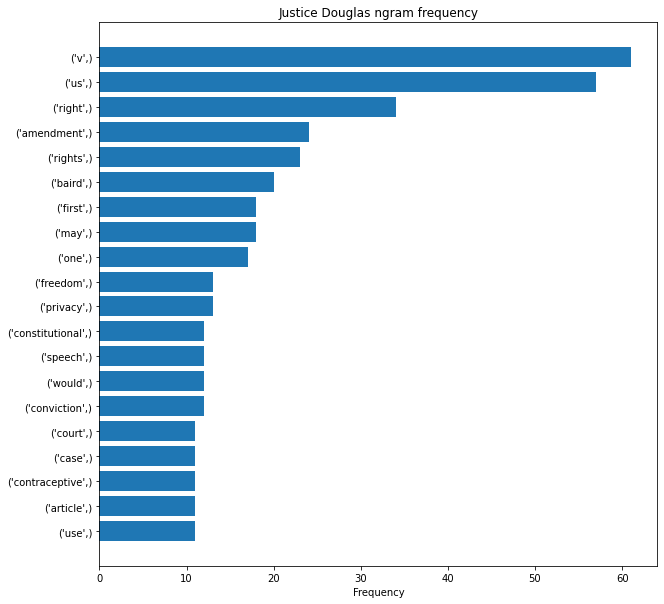

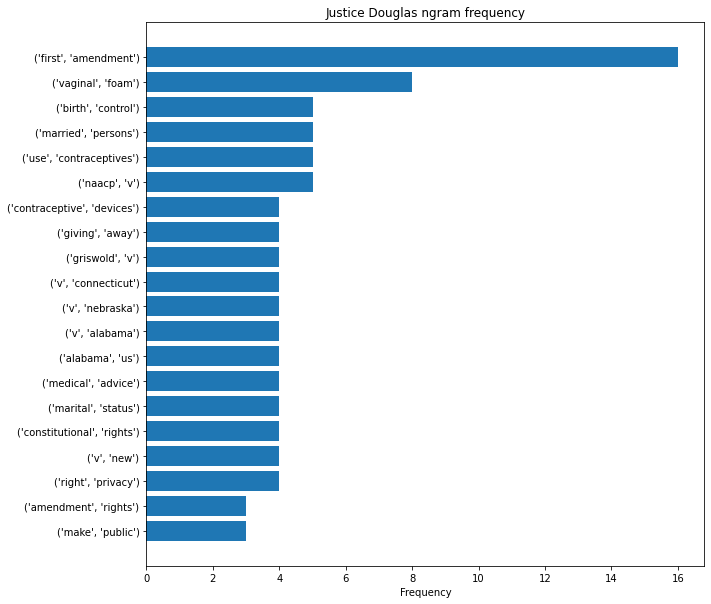

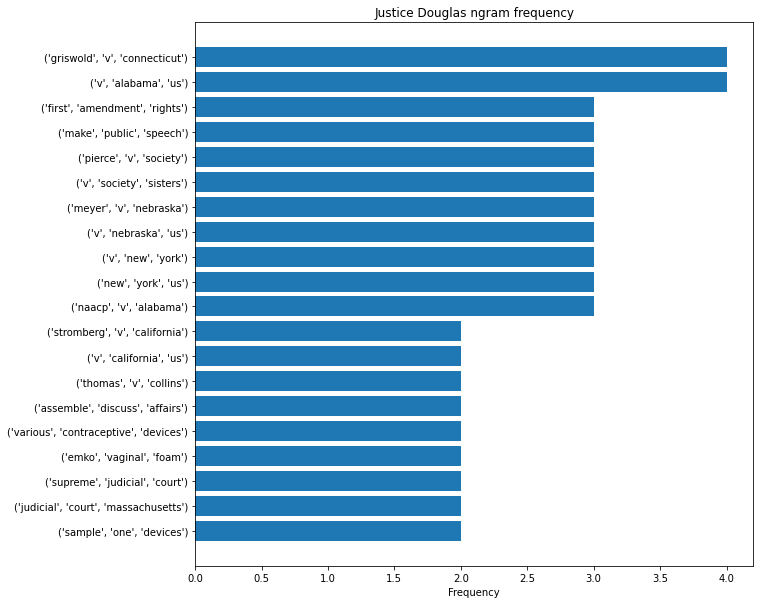

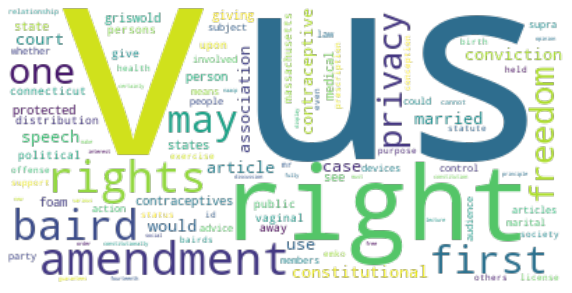

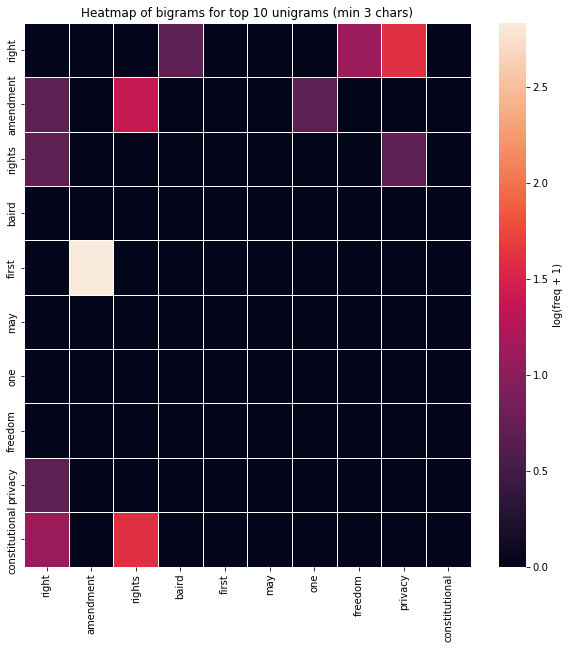

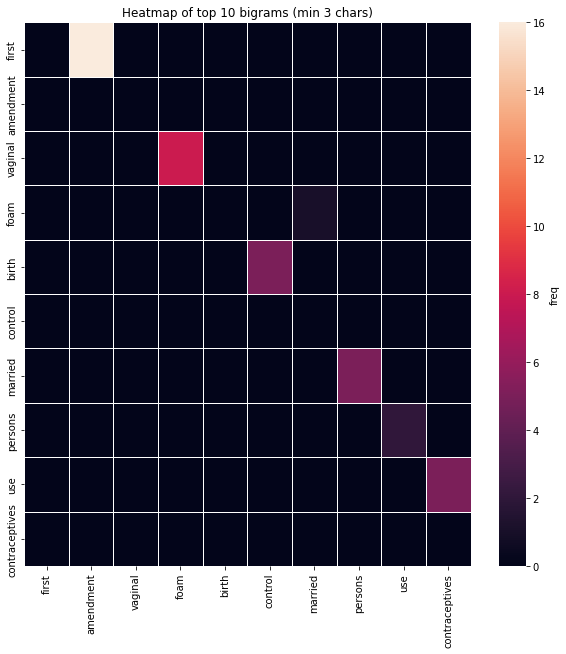

Justice Alito
	 unigrams:
		('court',) 450
		('see',) 328
		('case',) 310
		('petitioners',) 310
		('v',) 284
		('would',) 281
		('abortion',) 232
		('clinics',) 228
		('us',) 217
		('b',) 208
	 bigrams:
		('h', 'b') 156
		('admitting', 'privileges') 153
		('j', 'dissenting') 139
		('alito', 'j') 129
		('privileges', 'requirement') 114
		('cite', 'u') 88
		('whole', 'womans') 84
		('womans', 'health') 84
		('first', 'case') 81
		('health', 'v') 75
	 trigrams:
		('alito', 'j', 'dissenting') 126
		('admitting', 'privileges', 'requirement') 99
		('whole', 'womans', 'health') 84
		('womans', 'health', 'v') 75
		('health', 'v', 'hellerstedt') 66
		('v', 'hellerstedt', 'alito') 66
		('hellerstedt', 'alito', 'j') 63
		('cite', 'u', 'alito') 63
		('u', 'alito', 'j') 63
		('see', 'appendix', 'infra') 27


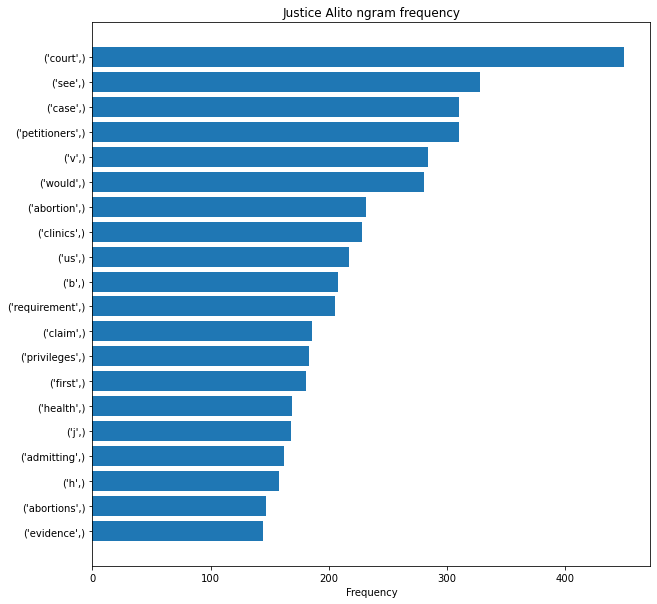

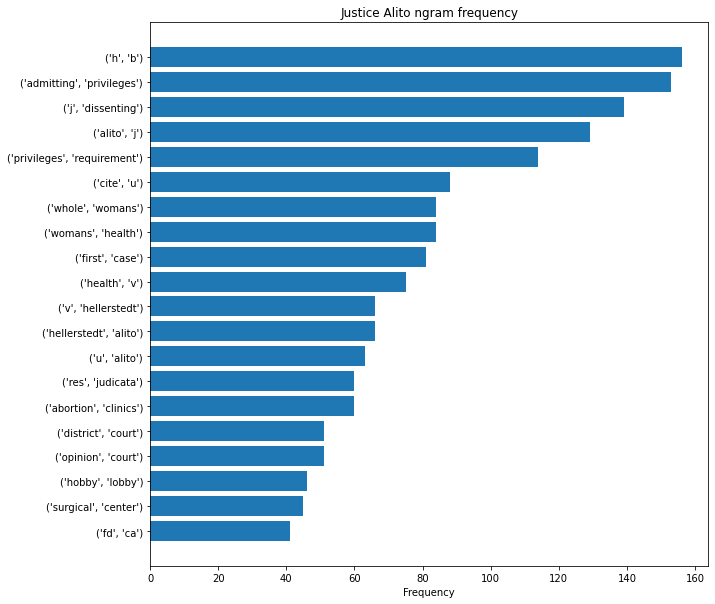

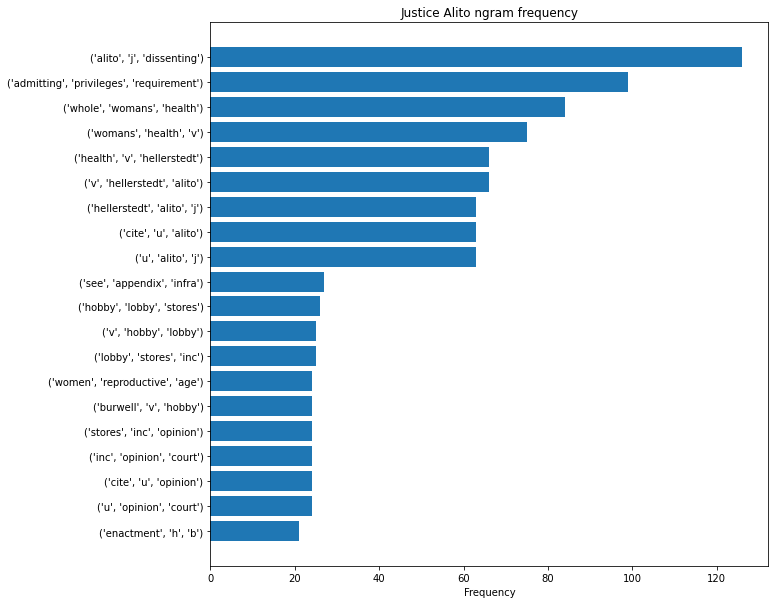

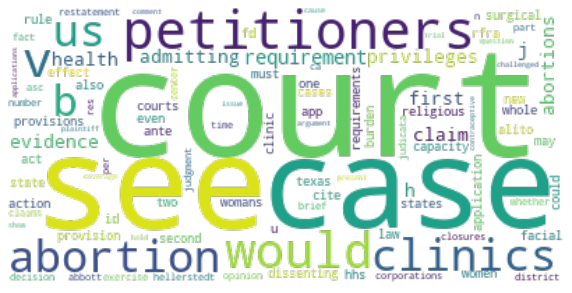

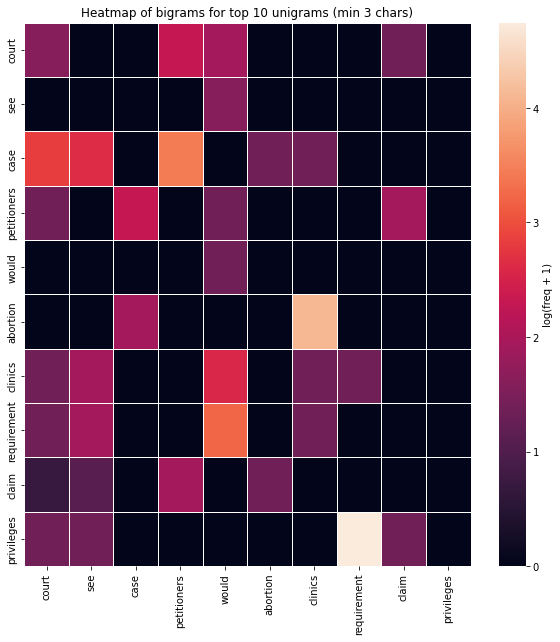

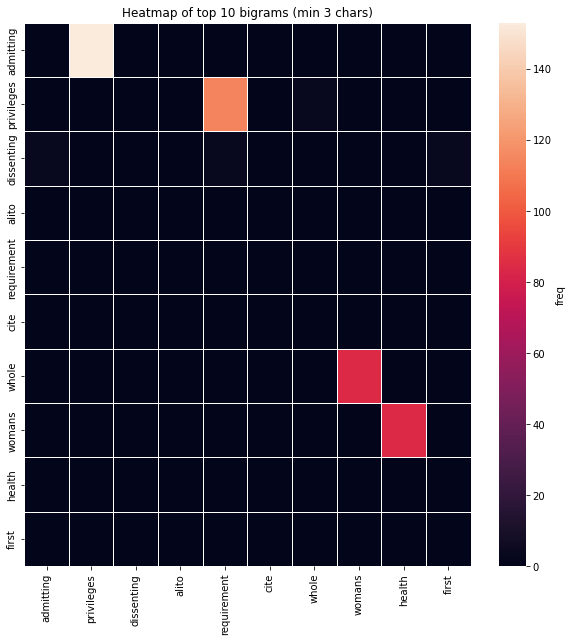

Justice Stevens
	 unigrams:
		('gruesome',) 4
		('rhetoric',) 3
		('reason',) 3
		('procedure',) 3
		('one',) 3
		('much',) 2
		('today',) 2
		('procedures',) 2
		('believe',) 2
		('nebraska',) 2
	 bigrams:
		('procedure', 'nebraska') 2
		('nebraska', 'claims') 2
		('equally', 'gruesome') 2
		('legitimate', 'interest') 2
		('although', 'much') 1
		('much', 'ink') 1
		('ink', 'spilled') 1
		('spilled', 'today') 1
		('today', 'describing') 1
		('describing', 'gruesome') 1
	 trigrams:
		('procedure', 'nebraska', 'claims') 2
		('although', 'much', 'ink') 1
		('much', 'ink', 'spilled') 1
		('ink', 'spilled', 'today') 1
		('spilled', 'today', 'describing') 1
		('today', 'describing', 'gruesome') 1
		('describing', 'gruesome', 'nature') 1
		('gruesome', 'nature', 'lateterm') 1
		('nature', 'lateterm', 'abortion') 1
		('lateterm', 'abortion', 'procedures') 1


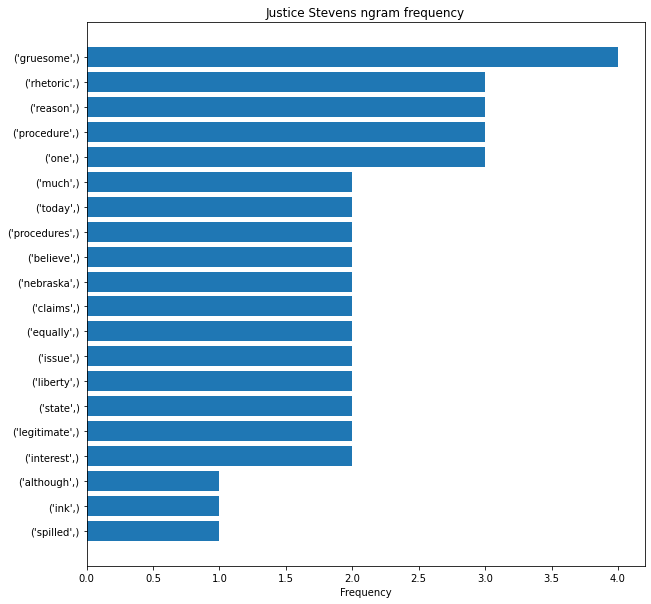

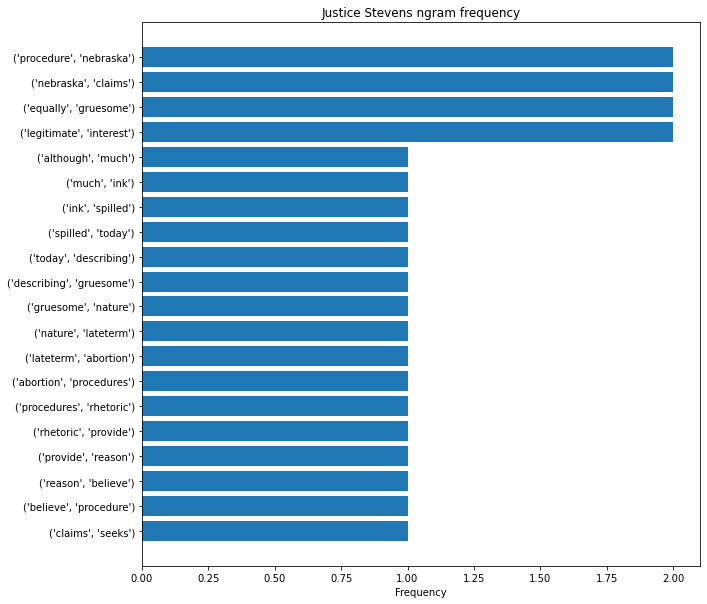

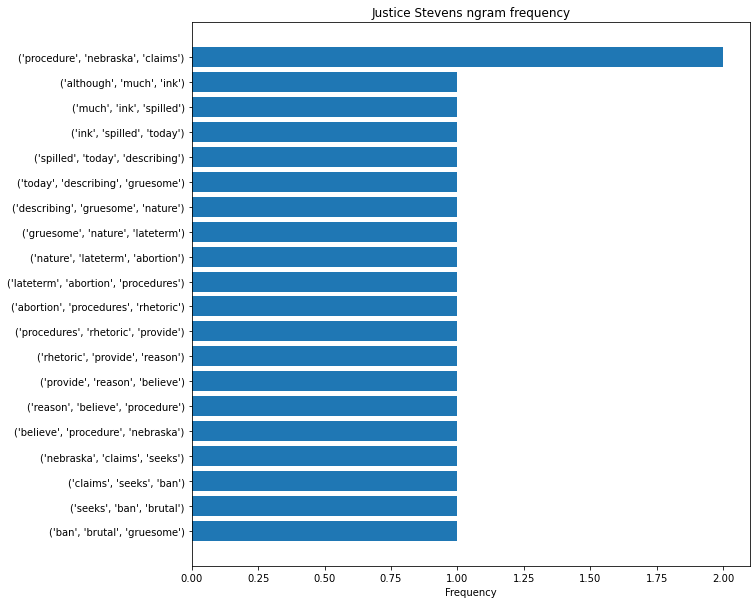

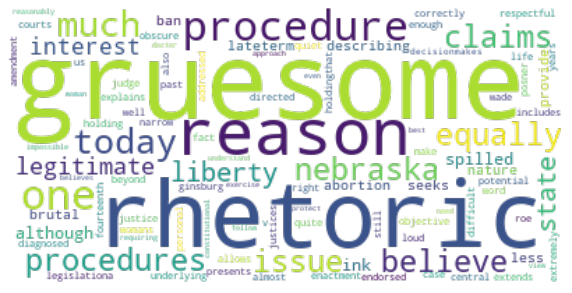

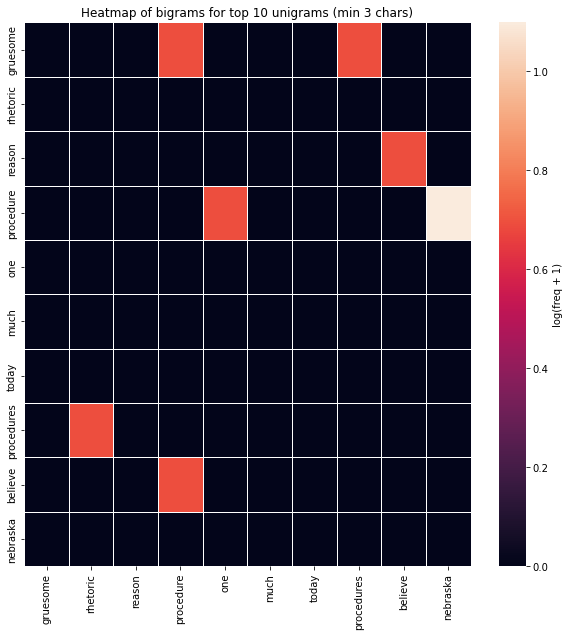

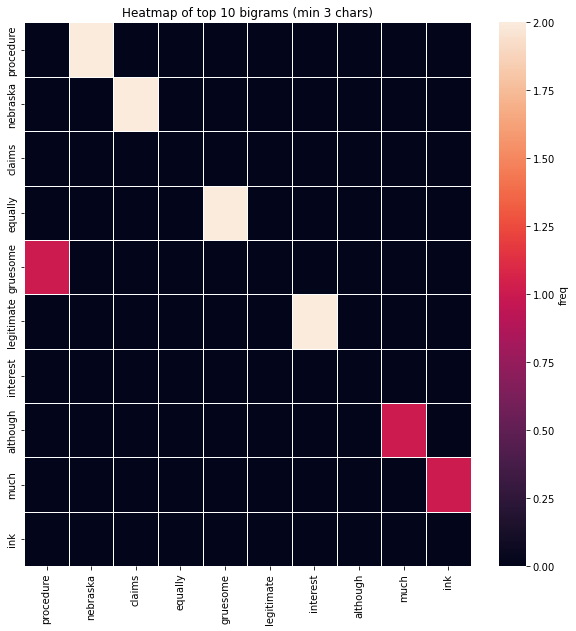

Justice Burger
	 unigrams:
		('health',) 17
		('contraceptives',) 16
		('massachusetts',) 14
		('court',) 13
		('state',) 12
		('statute',) 11
		('opinion',) 10
		('appellee',) 9
		('must',) 9
		('matter',) 9
	 bigrams:
		('appellees', 'conviction') 4
		('mr', 'justice') 4
		('dispensing', 'medicinal') 3
		('dispensing', 'contraceptives') 3
		('validity', 'restriction') 3
		('restriction', 'dispensing') 3
		('medicinal', 'substances') 3
		('contraceptives', 'dispensed') 3
		('united', 'states') 3
		('justice', 'white') 3
	 trigrams:
		('mr', 'justice', 'white') 3
		('supreme', 'judicial', 'court') 2
		('judicial', 'court', 'massachusetts') 2
		('united', 'states', 'v') 2
		('health', 'hazards', 'particular') 2
		('contraceptives', 'dispensed', 'medical') 2
		('dispensed', 'medical', 'channels') 2
		('distribution', 'medicinal', 'substances') 2
		('griswold', 'v', 'connecticut') 2
		('means', 'birth', 'control') 2


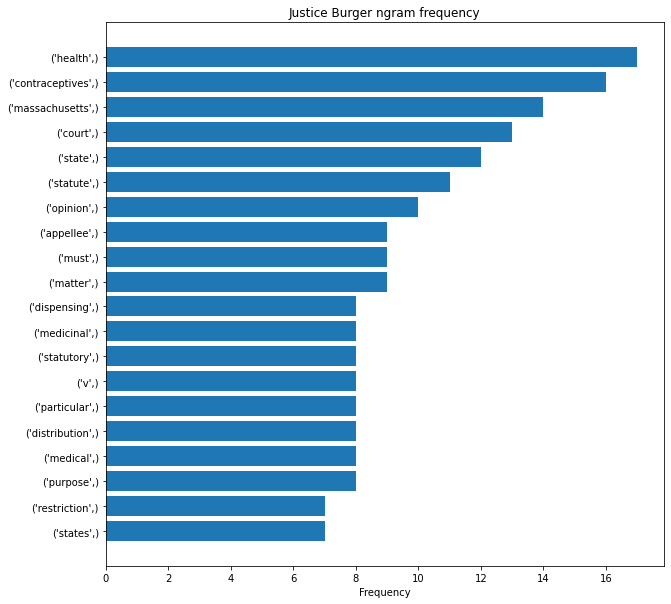

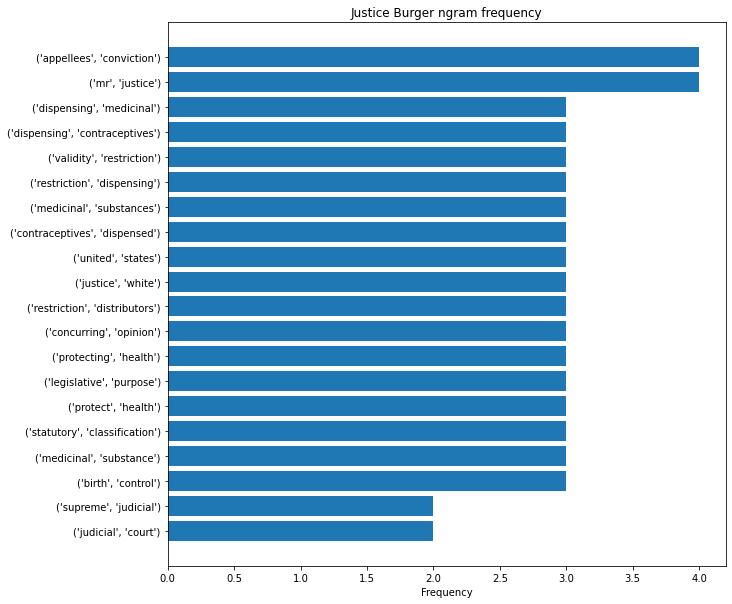

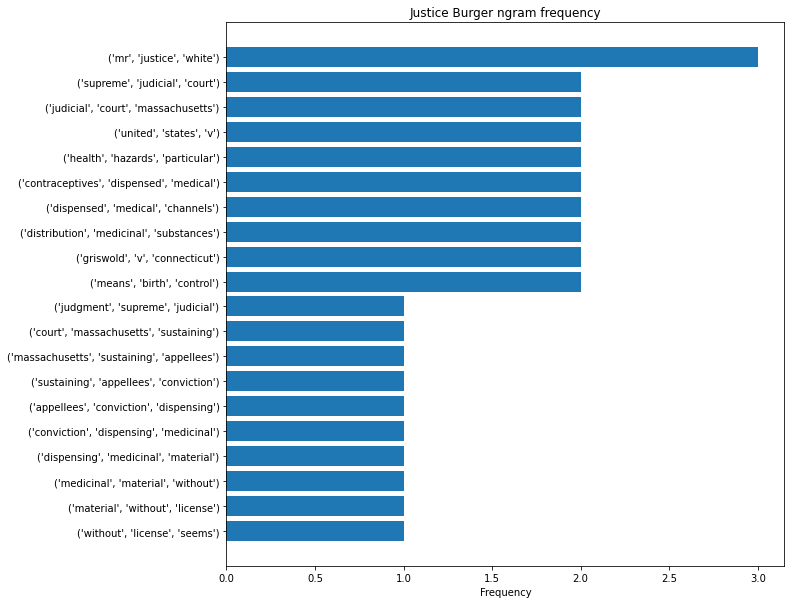

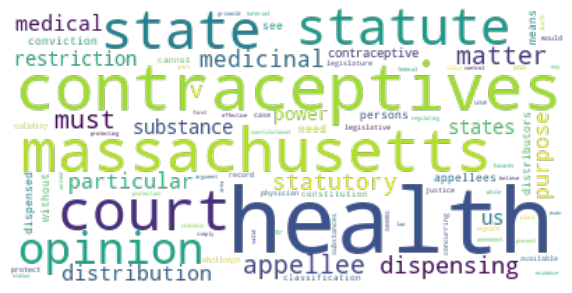

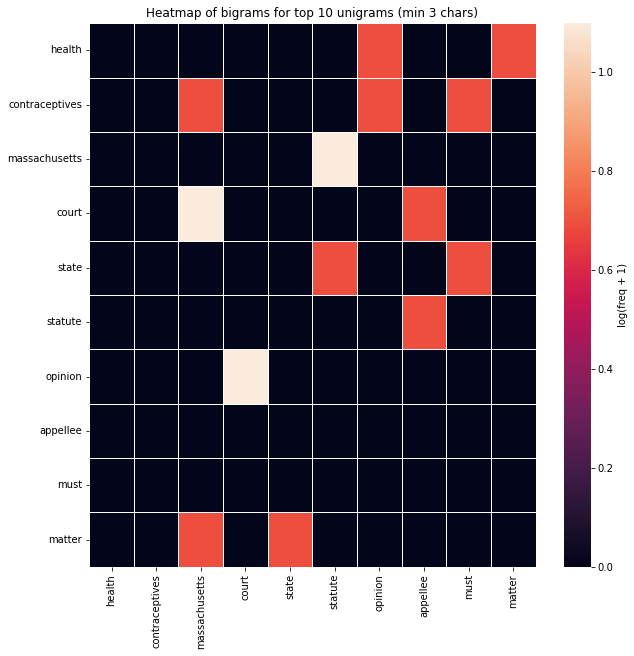

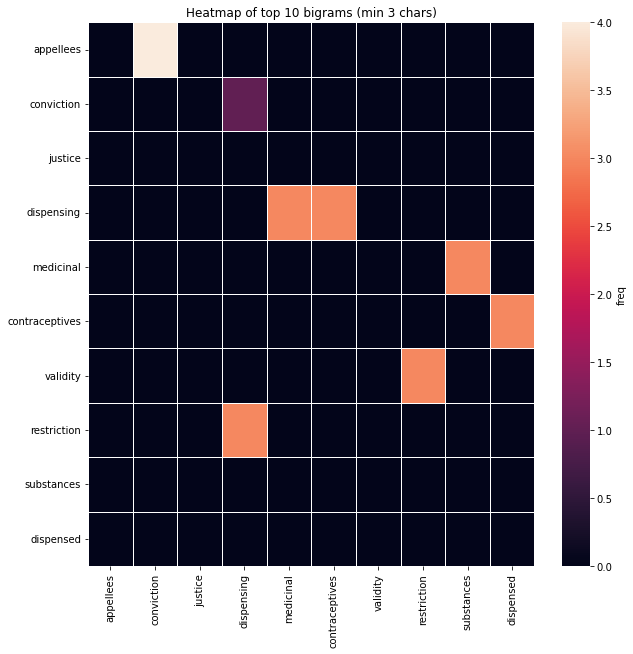

Justice Goldberg
	 unigrams:
		('v',) 70
		('us',) 60
		('rights',) 45
		('amendment',) 43
		('state',) 35
		('fundamental',) 31
		('right',) 29
		('court',) 28
		('constitution',) 26
		('connecticut',) 23
	 bigrams:
		('ninth', 'amendment') 21
		('fourteenth', 'amendment') 18
		('due', 'process') 15
		('bill', 'rights') 12
		('first', 'eight') 11
		('fundamental', 'personal') 11
		('mr', 'justice') 10
		('v', 'ullman') 10
		('eight', 'amendments') 9
		('process', 'clause') 9
	 trigrams:
		('first', 'eight', 'amendments') 9
		('due', 'process', 'clause') 9
		('fundamental', 'personal', 'rights') 6
		('poe', 'v', 'ullman') 6
		('process', 'clause', 'fourteenth') 5
		('clause', 'fourteenth', 'amendment') 5
		('mclaughlin', 'v', 'florida') 5
		('right', 'marital', 'privacy') 4
		('us', 'dissenting', 'opinion') 4
		('v', 'massachusetts', 'us') 4


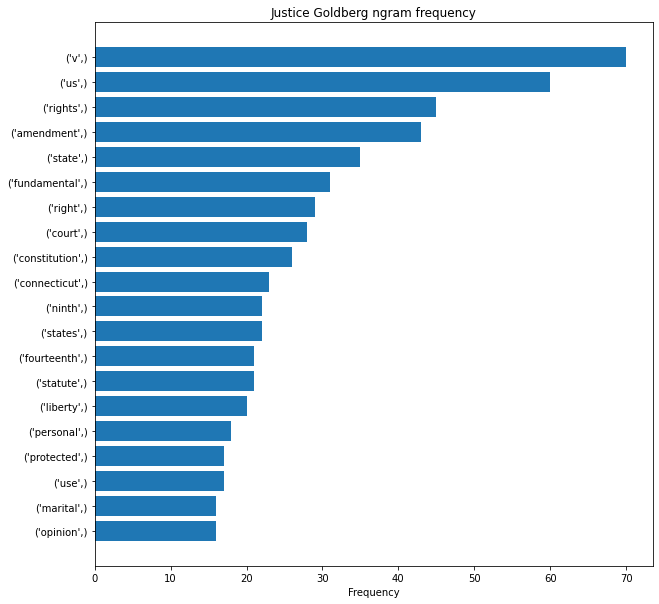

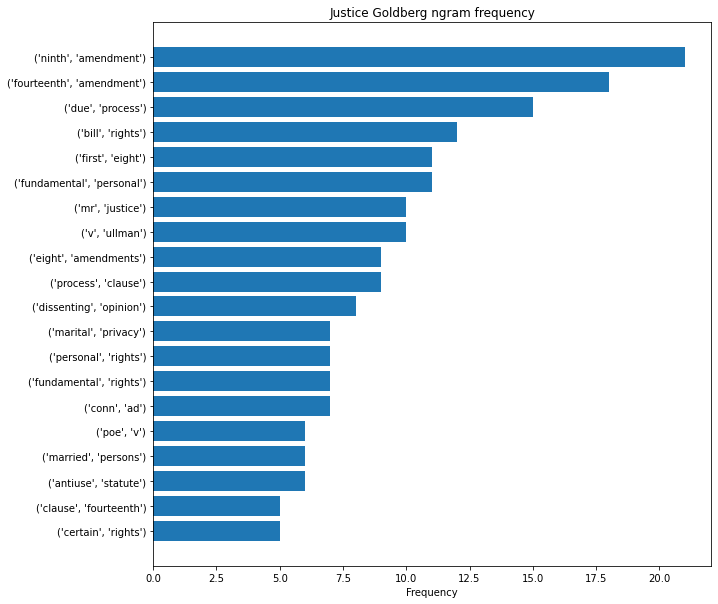

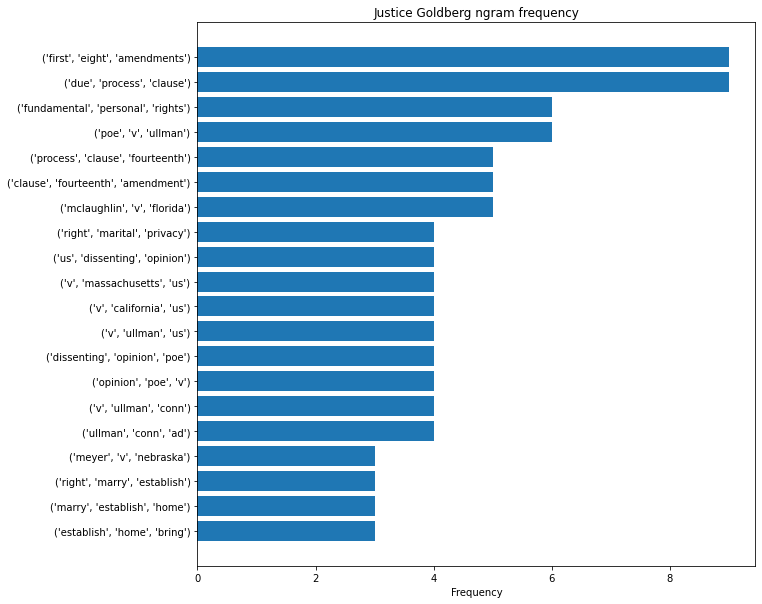

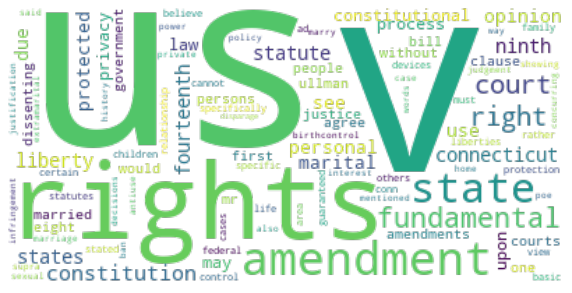

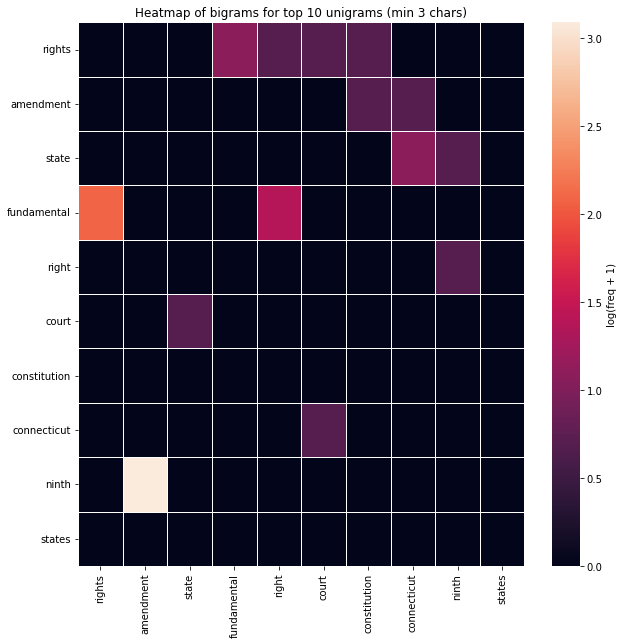

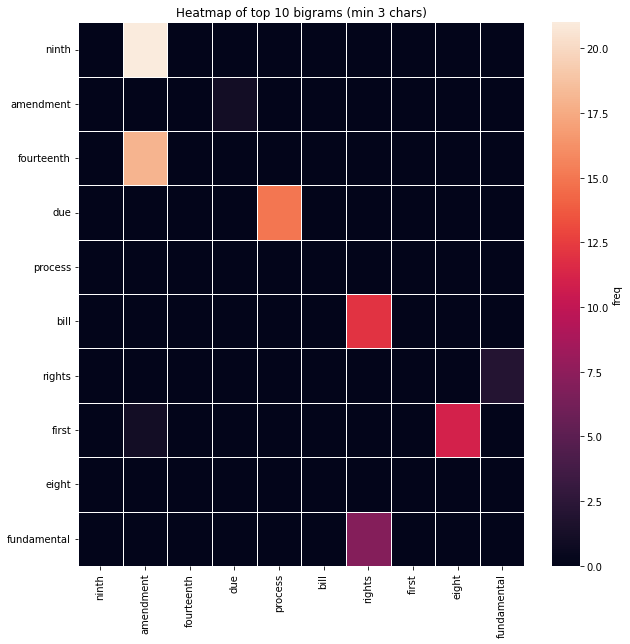

Justice Thomas
	 unigrams:
		('court',) 181
		('us',) 172
		('v',) 160
		('rights',) 120
		('j',) 105
		('abortion',) 103
		('see',) 95
		('casey',) 93
		('law',) 81
		('scrutiny',) 75
	 bigrams:
		('j', 'dissenting') 61
		('thomas', 'j') 59
		('undue', 'burden') 39
		('whole', 'womans') 30
		('womans', 'health') 30
		('health', 'v') 27
		('strict', 'scrutiny') 27
		('v', 'hellerstedt') 24
		('hellerstedt', 'thomas') 24
		('cite', 'u') 24
	 trigrams:
		('thomas', 'j', 'dissenting') 46
		('whole', 'womans', 'health') 30
		('womans', 'health', 'v') 27
		('health', 'v', 'hellerstedt') 24
		('v', 'hellerstedt', 'thomas') 24
		('hellerstedt', 'thomas', 'j') 24
		('internal', 'quotation', 'marks') 21
		('cite', 'u', 'thomas') 21
		('u', 'thomas', 'j') 21
		('women', 'seeking', 'abortions') 15


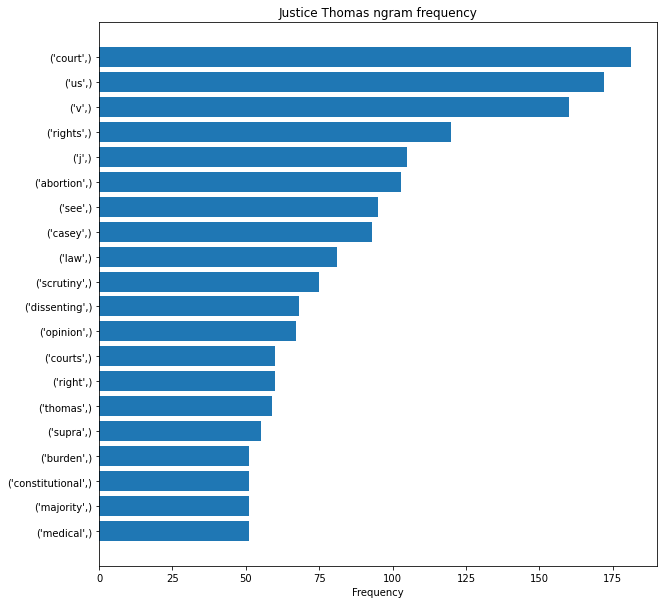

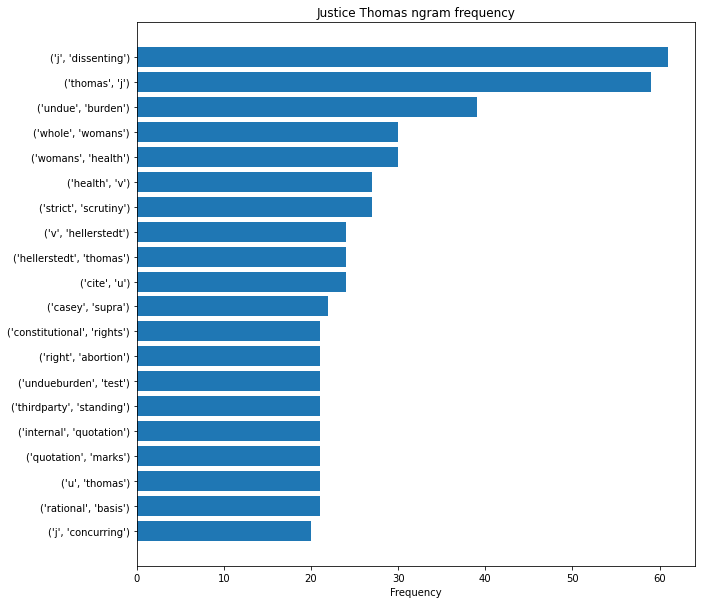

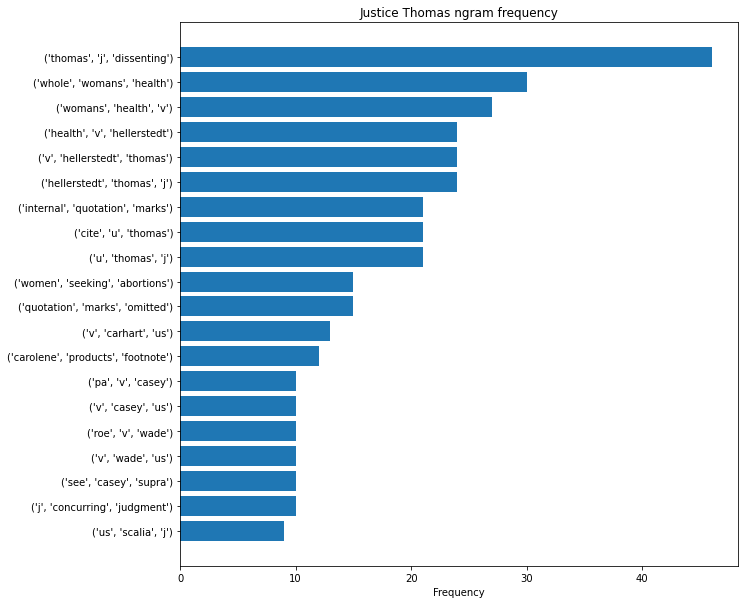

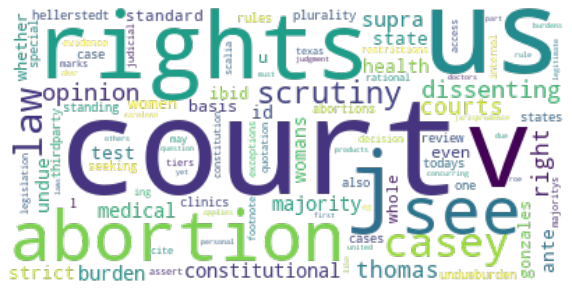

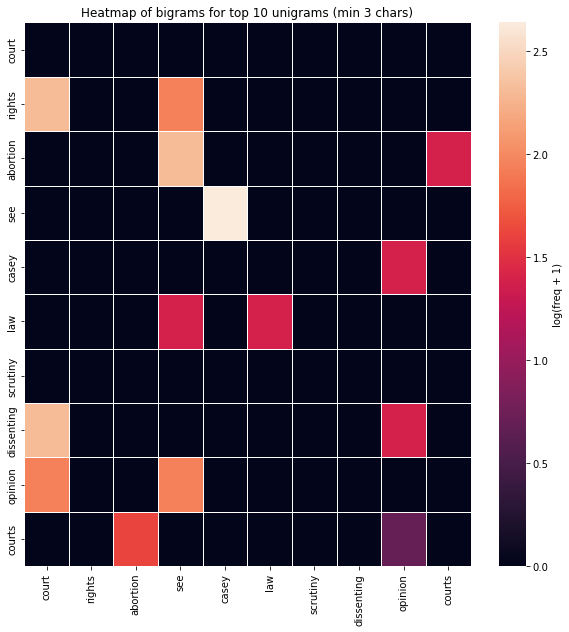

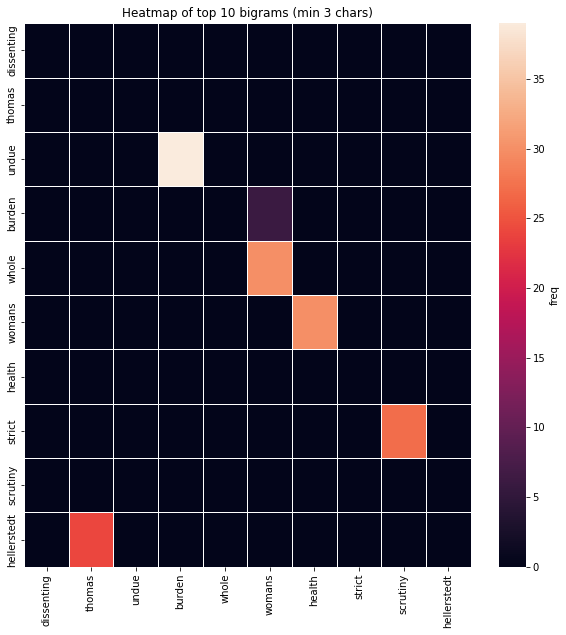

Justice Breyer
	 unigrams:
		('court',) 448
		('abortion',) 352
		('see',) 251
		('v',) 225
		('health',) 209
		('texas',) 201
		('requirement',) 193
		('opinion',) 187
		('district',) 163
		('id',) 156
	 bigrams:
		('opinion', 'court') 132
		('f', 'supp') 127
		('district', 'court') 109
		('court', 'appeals') 94
		('womans', 'health') 76
		('whole', 'womans') 75
		('health', 'v') 72
		('h', 'b') 63
		('v', 'hellerstedt') 60
		('hellerstedt', 'opinion') 60
	 trigrams:
		('whole', 'womans', 'health') 75
		('womans', 'health', 'v') 66
		('health', 'v', 'hellerstedt') 60
		('v', 'hellerstedt', 'opinion') 60
		('hellerstedt', 'opinion', 'court') 60
		('cite', 'u', 'opinion') 57
		('u', 'opinion', 'court') 57
		('f', 'supp', 'app') 24
		('admitting', 'privileges', 'requirement') 24
		('substantial', 'obstacle', 'path') 20


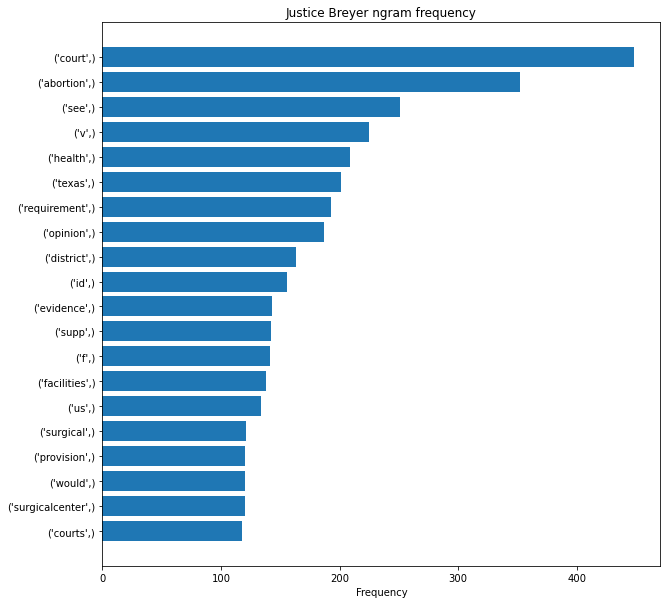

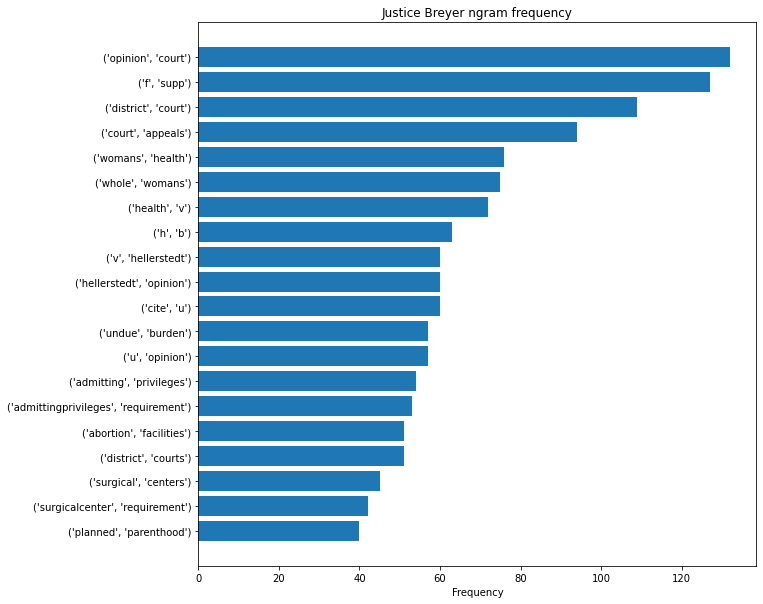

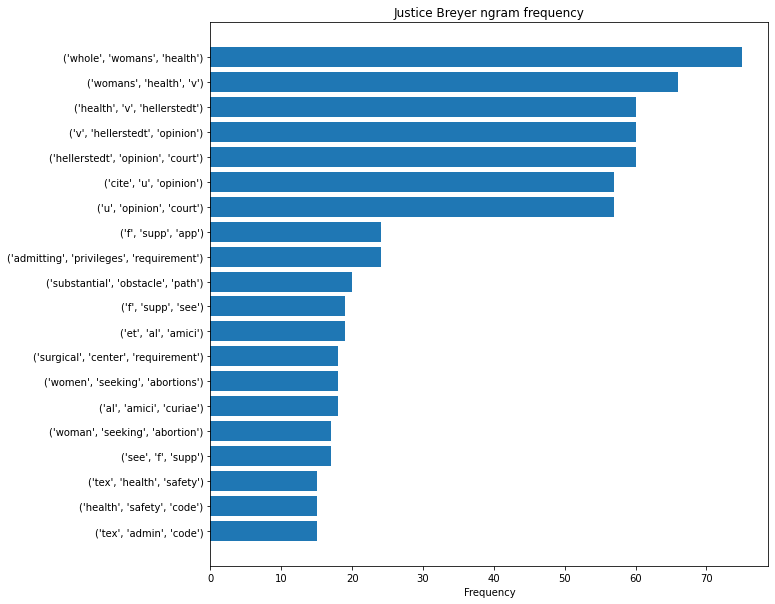

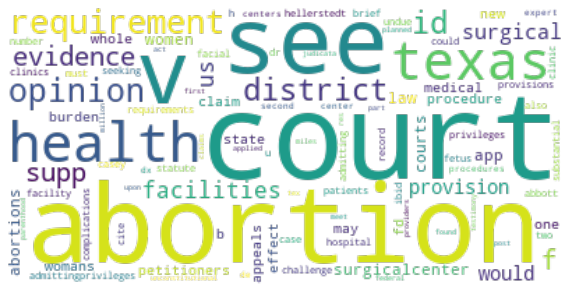

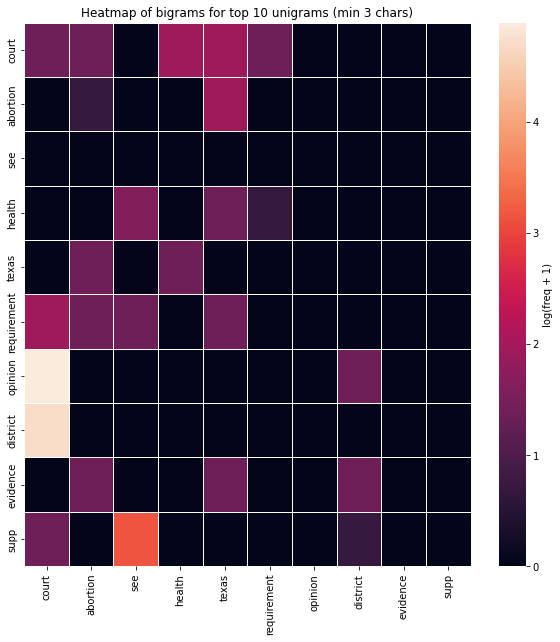

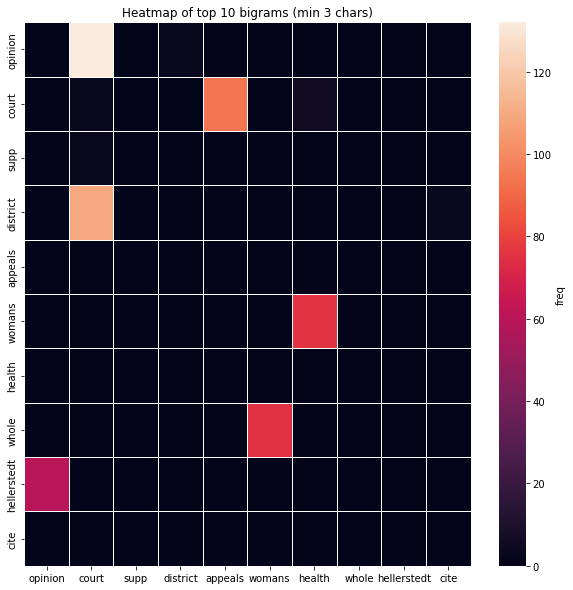

Justice Kennedy
	 unigrams:
		('act',) 126
		('abortion',) 106
		('fetus',) 105
		('e',) 94
		('ct',) 88
		('court',) 67
		('us',) 64
		('ed',) 64
		('see',) 59
		('intact',) 59
	 bigrams:
		('us', 'ct') 55
		('intact', 'e') 43
		('ct', 'l') 35
		('l', 'ed') 35
		('planned', 'parenthood') 30
		('ed', 'supp') 21
		('supp', 'iv') 21
		('see', 'also') 20
		('nat', 'abortion') 19
		('abortion', 'federation') 19
	 trigrams:
		('ct', 'l', 'ed') 35
		('us', 'ct', 'l') 33
		('ed', 'supp', 'iv') 21
		('nat', 'abortion', 'federation') 19
		('abortion', 'federation', 'supra') 11
		('usc', 'ed', 'supp') 10
		('planned', 'parenthood', 'fsuppd') 9
		('planned', 'parenthood', 'supra') 8
		('ct', 'plurality', 'opinion') 8
		('ba', 'ed', 'supp') 7


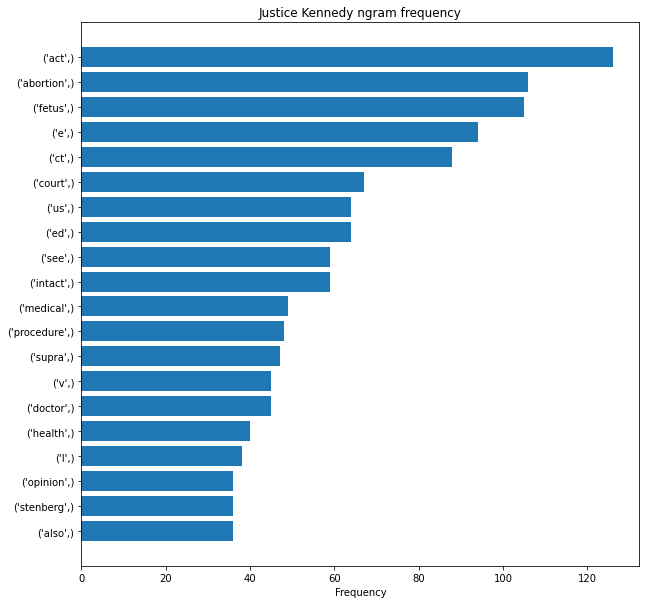

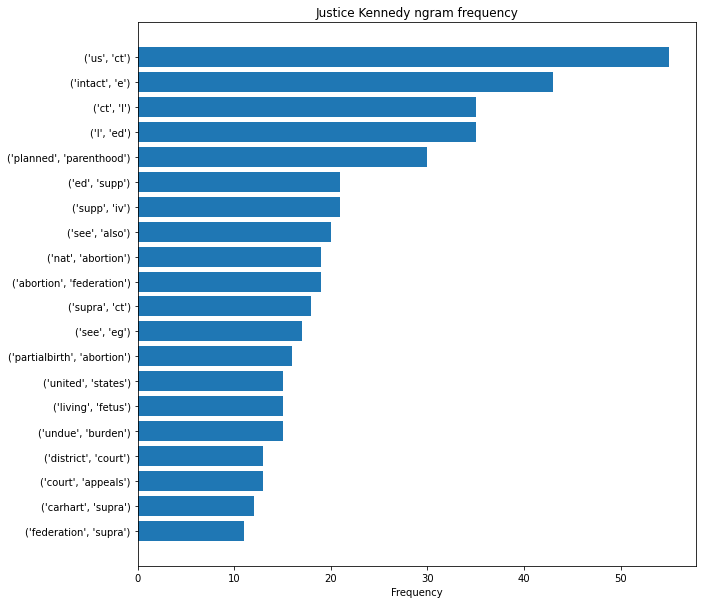

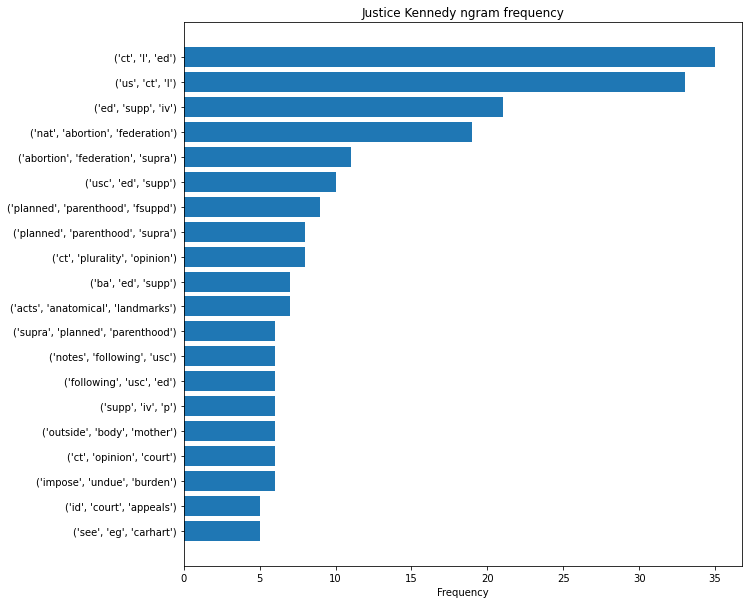

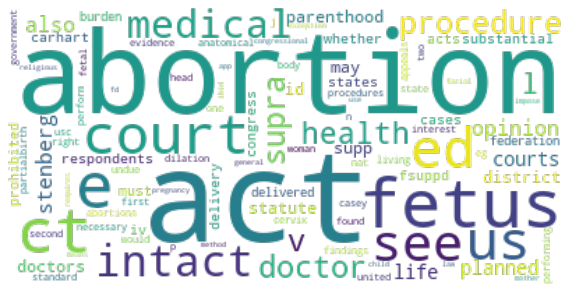

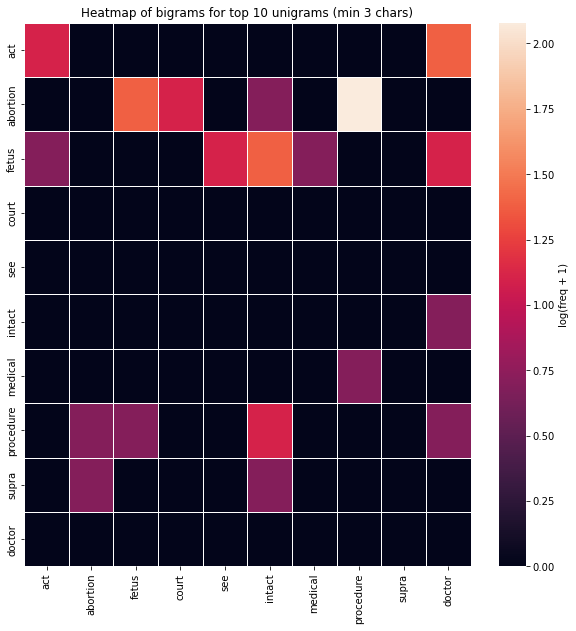

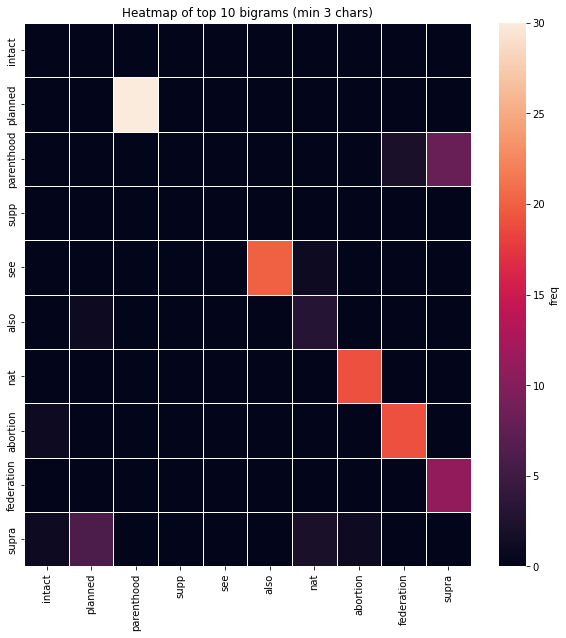

Justice Blackmun
	 unigrams:
		('abortion',) 137
		('v',) 101
		('state',) 81
		('us',) 66
		('life',) 64
		('medical',) 50
		('texas',) 42
		('pregnancy',) 42
		('court',) 37
		('states',) 36
	 bigrams:
		('criminal', 'abortion') 20
		('district', 'court') 17
		('f', 'supp') 16
		('pregnant', 'woman') 12
		('common', 'law') 12
		('fourteenth', 'amendment') 11
		('united', 'states') 10
		('th', 'century') 10
		('appeal', 'docketed') 10
		('post', 'p') 9
	 trigrams:
		('doe', 'v', 'bolton') 6
		('v', 'bolton', 'post') 5
		('bolton', 'post', 'p') 5
		('criminal', 'abortion', 'laws') 5
		('abele', 'v', 'markle') 5
		('end', 'first', 'trimester') 5
		('texas', 'criminal', 'abortion') 4
		('criminal', 'abortion', 'statutes') 4
		('f', 'supp', 'nd') 4
		('united', 'states', 'v') 4


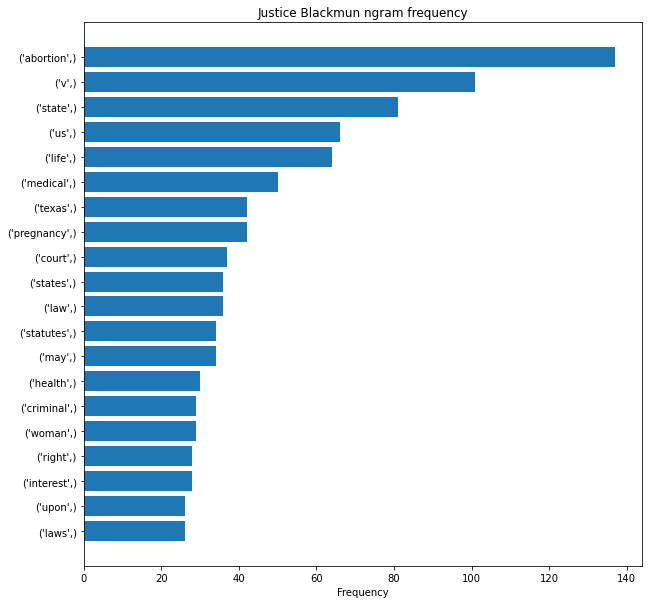

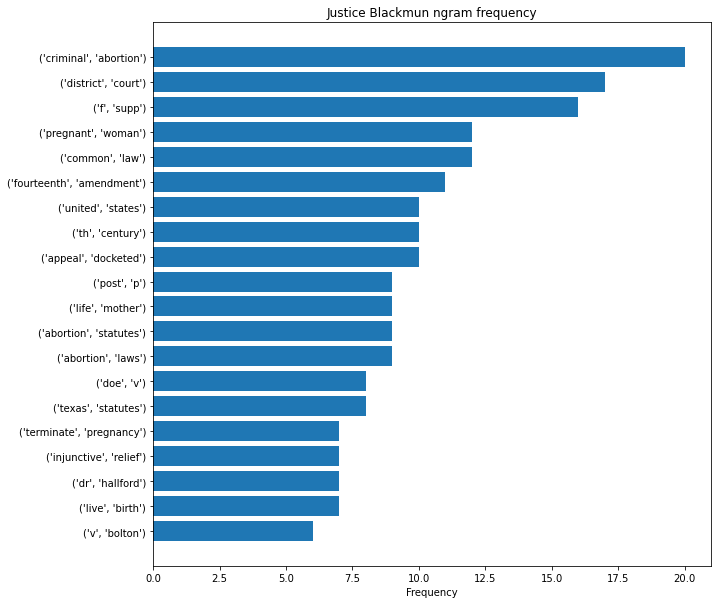

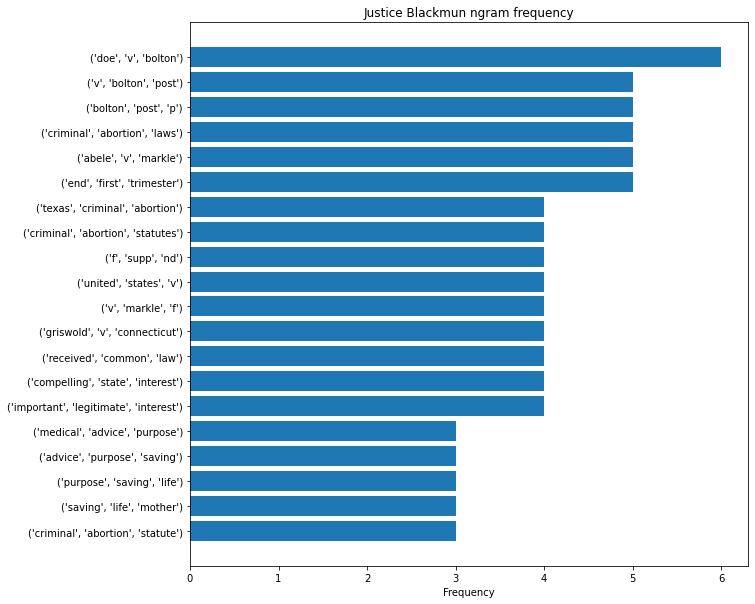

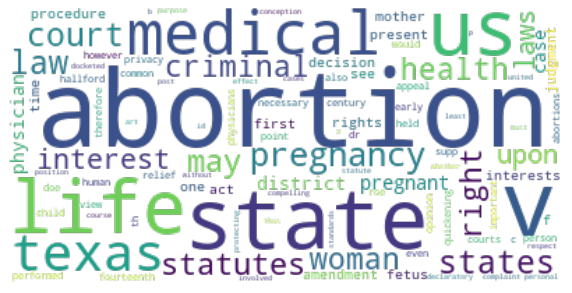

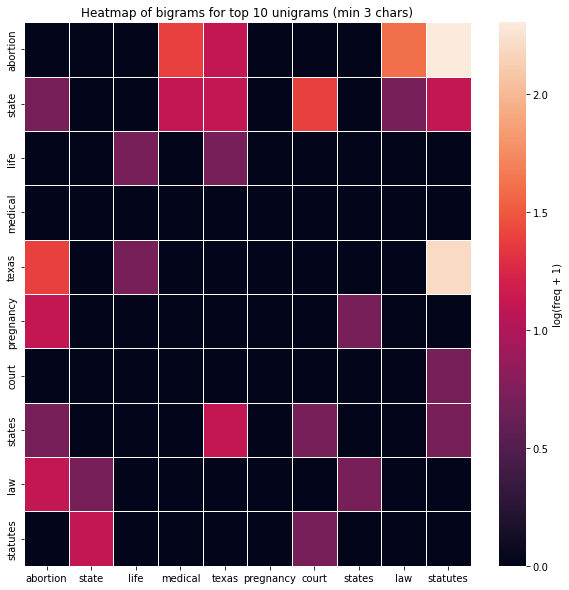

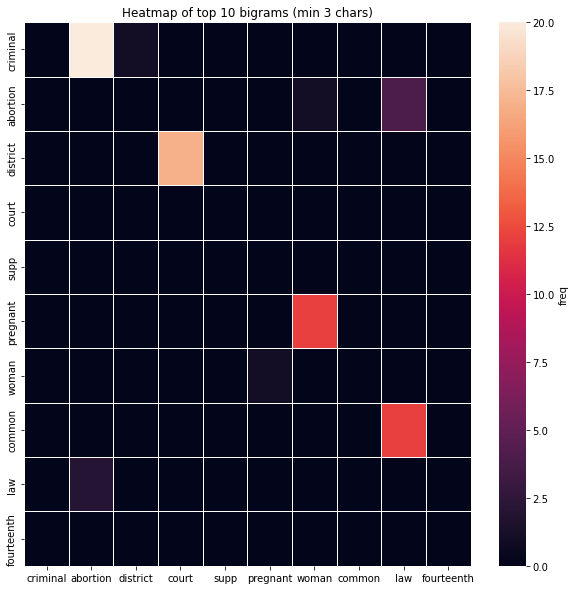

In [15]:
# https://en.wikipedia.org/wiki/List_of_landmark_court_decisions_in_the_United_States#Birth_control_and_abortion
landmark_cases = [
    "Griswold v. Connecticut",
    "Eisenstadt v. Baird",
    "Roe v. Wade",
    "Carey v. Population Services International",
    "Planned Parenthood v. Casey",
    "Stenberg v. Carhart",
    "Gonzales v. Carhart",
    "Burwell v. Hobby Lobby Stores, Inc.",
    "Whole Woman's Health v. Hellerstedt"
]
author_names = None
# cases = print_cases(all_opinions)
# for case_name in landmark_cases:
    # print(f'{case_name} available: {case_name in cases}') 
cases, justices, opinions = select_opinions_df(all_opinions, author_names=author_names, case_names=landmark_cases)
landmark_counter = opinion_counter(opinions)
for j in justices:
    summarize(landmark_counter, j)

In [16]:
print_cases(all_opinions.loc[all_opinions['year_filed'].isin([1977, 1976, 1978])])

472 cases


['East Carroll Parish School Bd. v. Marshall',
 'United States v. Mauro',
 'Key v. Doyle',
 'Hicklin v. Orbeck',
 'Stump v. Sparkman',
 "FIRST FEDERAL S. & L. v. Massachusetts Tax Comm'n",
 'National Boiler Marketing Assn. v. United States',
 'United States v. Martinez-Fuerte',
 "United States Steel Corp. v. Multistate Tax Comm'n",
 'Davis v. Georgia',
 'Califano v. Sanders',
 'Ohio Bureau of Employment Servs. v. Hodory',
 'Califano v. Torres',
 'Marks v. United States',
 'United States v. Santana',
 'Donovan v. Penn Shipping Co.',
 'Electrical Workers v. Robbins & Myers, Inc.',
 'Paul v. Davis',
 'United States v. Ceccolini',
 'Smith v. Digmon',
 'United States v. Ramsey',
 'McKinney v. Alabama',
 'Bankers Trust Co. v. Mallis',
 'Burks v. United States',
 'Taylor v. Kentucky',
 'Runyon v. McCrary',
 'Ohio v. Gallagher',
 'Patterson v. New York',
 'Sanabria v. United States',
 'Santa Fe Industries, Inc. v. Green',
 'Pennsylvania v. Mimms',
 'Nashville Gas Co. v. Satty',
 'United States

Justices appointed by party: (Democratic, Republican)
Category of opinion: (Dissenting , Concurring, Majority)

For each case:
    determine which 'party' had majority justices for a decision
    According to asym poli: there should be less agreement across parties as time goes on
        Polarization => Asymmetric polarization (levels of analysis)
            If it polarizes, is it asymmetric?
        For different presidential terms (political mood): split cases by presidential term and evaluate stats
    Do certain decisions/categories occur for certain presidential party?
    

In [19]:
from src.data import Complex

a = Complex(1,0)

In [21]:
a.r

1